In [2]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv
import pandas as pd
import scipy

# Investigate how bootstrap confidence intervals are affected by upscaling (bayNorm)

Consider the 'SS3_c57_UMIs_concat.csv' dataset:
- observed counts (original)
- MAP counts (argmax count of posterior)
- Posterior sample counts (20 sampled counts from posterior)

Take the sample of counts for a gene for all 3, bootstrap to produce confidence intervals for all states ('s stationary values), plot them against the histogram of the (stationary) sample:

### Load datasets

In [3]:
# Observed count data
data_OB = pd.read_csv("..\Data\SS3_c57_UMIs_concat_cleaned.csv", index_col="Unnamed: 0")
data_OB.head()

,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S18,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S1,SS3_MAF_Leo171129_p2_S20,...,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S186,SS3_MAF_leo180223_p4_S187,SS3_MAF_leo180223_p4_S191,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610007P14Rik,0.0,2.0,2.0,2.0,1.0,4.0,4.0,4.0,7.0,2.0,...,1.0,3.0,0.0,1.0,2.0,9.0,4.0,0.0,0.0,0.0
0610009B22Rik,10.0,4.0,NaN,NaN,0.0,14.0,26.0,6.0,1.0,2.0,...,6.0,5.0,2.0,1.0,14.0,0.0,1.0,4.0,3.0,2.0
0610031J06Rik,17.0,18.0,9.0,14.0,0.0,9.0,6.0,22.0,1.0,10.0,...,18.0,9.0,3.0,2.0,8.0,31.0,15.0,1.0,1.0,2.0
1110007C09Rik,1.0,0.0,4.0,9.0,0.0,0.0,NaN,0.0,NaN,0.0,...,4.0,2.0,NaN,6.0,0.0,0.0,5.0,0.0,2.0,0.0
1110037F02Rik,0.0,0.0,4.0,0.0,2.0,10.0,0.0,2.0,8.0,0.0,...,2.0,4.0,0.0,1.0,4.0,3.0,6.0,0.0,0.0,3.0


In [4]:
# MAP count data
data_MAP = pd.read_csv("..\Data\SS3_c57_UMIs_concat_MAP.csv", index_col="Unnamed: 0")
data_MAP.head()

,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S18,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S1,SS3_MAF_Leo171129_p2_S20,...,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S186,SS3_MAF_leo180223_p4_S187,SS3_MAF_leo180223_p4_S191,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610007P14Rik,1,22,23,24,13,21,29,35,76,16,...,11,28,2,26,21,76,40,1,2,2
0610009B22Rik,133,49,10,10,11,75,186,58,20,22,...,69,52,60,43,144,7,18,59,59,48
0610031J06Rik,272,230,139,205,34,60,62,224,41,105,...,228,111,144,133,113,294,184,48,64,91
1110007C09Rik,12,0,48,114,0,0,0,0,0,0,...,44,18,0,184,0,0,53,0,34,0
1110037F02Rik,6,5,44,5,27,51,3,19,80,4,...,23,37,10,28,40,26,57,6,7,50


In [5]:
# Posterior sample count data
data_PS = pd.read_csv("..\Data\SS3_c57_UMIs_concat_PosteriorSamples.csv", index_col="Unnamed: 0")
data_PS.head()

,SS3_MAF_Leo171129_p2_S10.1,SS3_MAF_Leo171129_p2_S12.1,SS3_MAF_Leo171129_p2_S13.1,SS3_MAF_Leo171129_p2_S14.1,SS3_MAF_Leo171129_p2_S16.1,SS3_MAF_Leo171129_p2_S17.1,SS3_MAF_Leo171129_p2_S18.1,SS3_MAF_Leo171129_p2_S19.1,SS3_MAF_Leo171129_p2_S1.1,SS3_MAF_Leo171129_p2_S20.1,...,SS3_MAF_leo180223_p4_S182.20,SS3_MAF_leo180223_p4_S186.20,SS3_MAF_leo180223_p4_S187.20,SS3_MAF_leo180223_p4_S191.20,SS3_MAF_leo180223_p4_S185.20,SS3_MAF_leo180223_p4_S189.20,SS3_MAF_leo180223_p4_S188.20,SS3_MAF_leo180223_p4_S190.20,SS3_MAF_leo180223_p4_S98.20,SS3_MAF_leo180223_p4_S99.20
0610007P14Rik,2,60,54,46,26,8,35,19,106,17,...,10,12,22,37,22,62,55,25,18,23
0610009B22Rik,121,59,30,15,42,61,230,58,39,54,...,30,41,114,57,209,4,38,48,92,53
0610031J06Rik,234,268,195,198,56,44,113,203,76,85,...,255,110,170,211,165,358,165,57,173,226
1110007C09Rik,79,11,34,106,2,1,0,7,11,4,...,44,21,44,210,1,2,99,19,36,9
1110037F02Rik,20,0,79,21,17,93,14,24,47,8,...,30,57,61,137,77,29,67,12,36,37


### Bootstrap code

In [6]:
def bootstrap_data(x_list, samples, N, plot=False, printing=False):
    """
    Bootstrap sample data to find confidence intervals of
    stationary distribution values.

    Inputs:
    x_list: states to calculate stationary estimates for
    samples: list of samples from stationary distribution (counts of transcripts)
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of states in x_list
    """

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    n = len(samples)
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(samples,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return intervals

In [6]:
def CI_analysis(sample, N):
    """
    Given a sample from a (stationary) distribution, create N bootstrap samples
    and estimate confidence intervals for all probabilities in the distribution,
    plot sample and CI's
    """
    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data([x for x in range(x_max + 1)], sample, N)

    # average width (4 d.p)
    avg_width = np.mean([interval[1] - interval[0] for interval in intervals])
    avg_width = float(str(avg_width)[:6])

    # plot sample and CI bounds
    label_dot = "[0, 0] CI"
    label_int = "Confidence interval"
    for i, interval in enumerate(intervals):
        if interval[0] == interval[1]:
            # plot dot for CI of width 0
            plt.plot(i, 0, 'go', label = label_dot)
            # avoid repeated legend
            label_dot = ""
        else:
            plt.plot([i, i], [interval[0], interval[1]], color="red", label = label_int)
            # avoid repeated legend
            label_int = ""
    plt.hist(sample, bins=np.arange(x_max) - 0.5, color="blue", label="Sample", alpha=0.5,
             density=True)
    plt.plot([0,0], label=f"Average bound width = {avg_width}")
    plt.title("Sample and estimated bounds for a gene's transcript count distribution")
    plt.legend()
    plt.show()

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


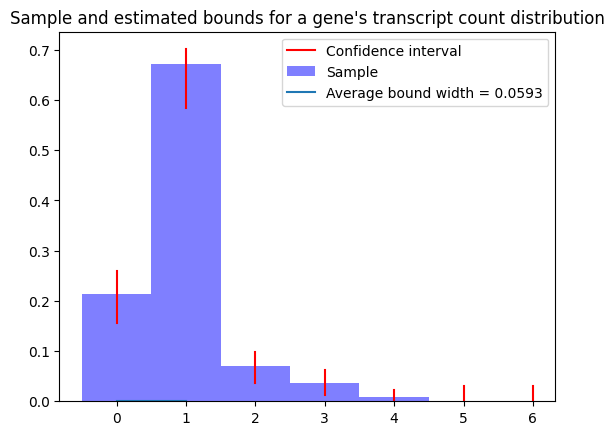

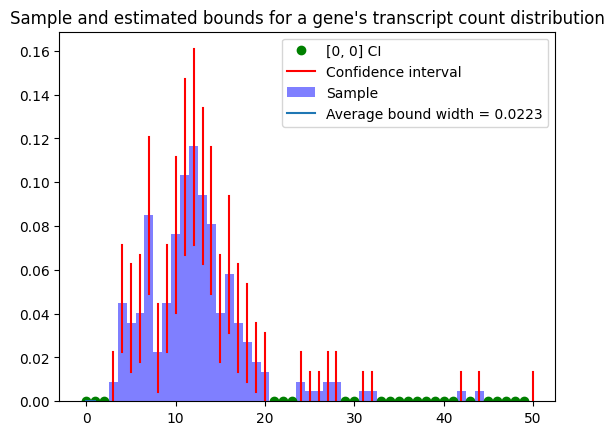

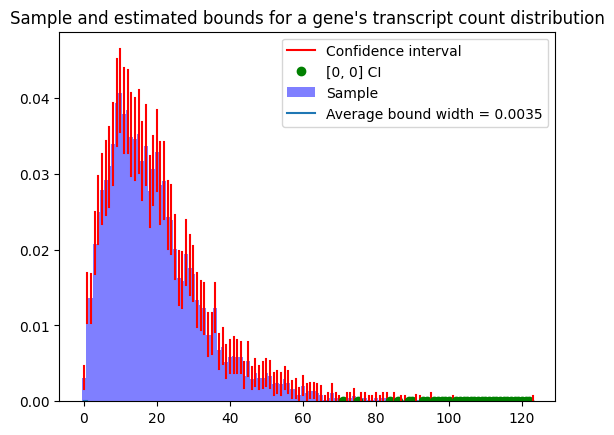

In [88]:
for data in [data_OB, data_MAP, data_PS]:
    sample = data.iloc[1483]
    CI_analysis(sample, 1000)

Increased spread of data from 0-6 to 0-50 for the MAP data, and to 0-120 and 20x sample size for PS data. MAP average width around half of observed, PS around a tenth, however likely strong influence of 0 width confidence intervals due to no observations for those states.

In [89]:
def cleaned_average_width(sample, N):
    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data([x for x in range(x_max + 1)], sample, N)

    avg_width = []
    for interval in intervals:
        if interval[0] != interval[1]:
            avg_width.append(interval[1] - interval[0])
    
    return np.mean(avg_width)

In [90]:
for data in [data_OB, data_MAP, data_PS]:
    sample = data.iloc[1483]
    avg_width = cleaned_average_width(sample, 1000)
    print(avg_width)

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


0.061240433673469395
0.04050940688775511
0.004854414682539683


Removing 0 width confidence intervals when computing average width there is now only a small reduction when using MAP data. However, still a significant reduction when using PS data: 20 times sample size has strong impact on CI width as seen in birth_death_reaction analysis, and likely increased accuracy towards the theoretical 95%.

In [93]:
rng = np.random.default_rng(33)
OB_widths = []
MAP_widths = []
PS_widths = []
for i in rng.choice(data_OB.shape[0], size = 10):
    for j in range(3):
        sample = [data_OB, data_MAP, data_PS][j].iloc[i]
        [OB_widths, MAP_widths, PS_widths][j].append(cleaned_average_width(sample, 1000))

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


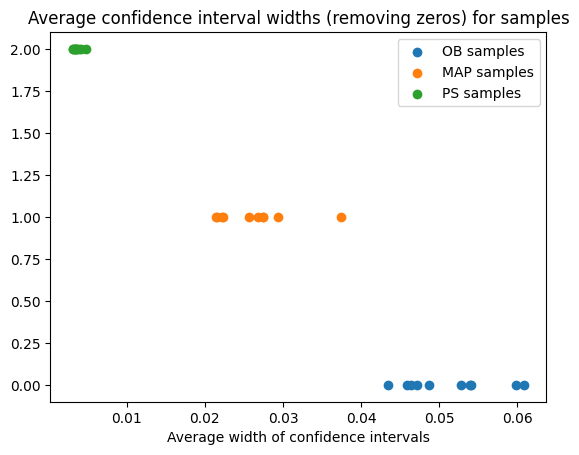

In [94]:
plt.scatter(OB_widths, [0] * len(OB_widths), label = "OB samples")
plt.scatter(MAP_widths, [1] * len(MAP_widths), label = "MAP samples")
plt.scatter(PS_widths, [2] * len(PS_widths), label = "PS samples")
plt.title("Average confidence interval widths (removing zeros) for samples")
plt.xlabel("Average width of confidence intervals")
plt.legend()
plt.show()

# Optimization

Current code for analysing samples: selecting state space truncation, bootstrapping sample and solving the selected LP. Currently quite slow even for the small number of states involved in OB data, but extremely so for the larger numbers of states in MAP and PS data.

Time bootstrap and LP solver for different numbers of states and equations, find optimizations

In [7]:
import time

## Timing bootstrap

In [99]:
def bootstrap_time(sample, n):
    """Time bootstrap for all states in sample, n = bootstrap samples."""
    start = time.time()
    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data([x for x in range(x_max + 1)], sample, n)

    # time
    end = time.time()

    # return: time elapsed, number of bounds estimated
    return (end - start, x_max + 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


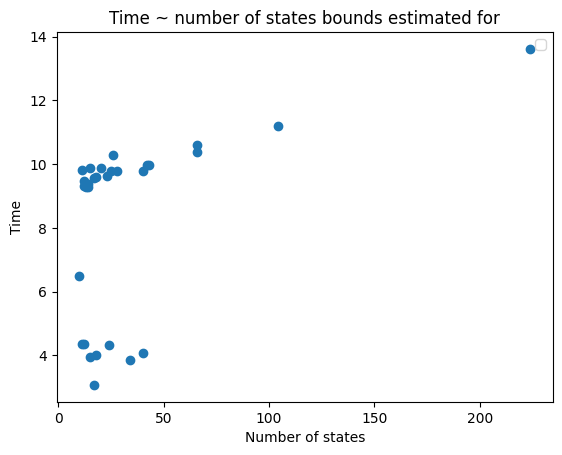

In [106]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_OB.shape[0], size = 30):
    sample = data_OB.iloc[i]
    t, s = bootstrap_time(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


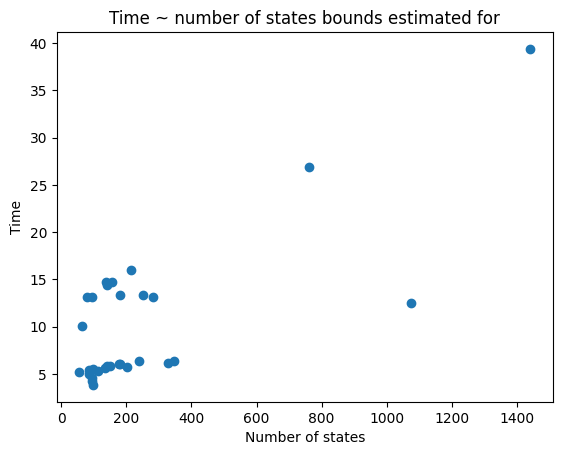

In [107]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_MAP.shape[0], size = 30):
    sample = data_MAP.iloc[i]
    t, s = bootstrap_time(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

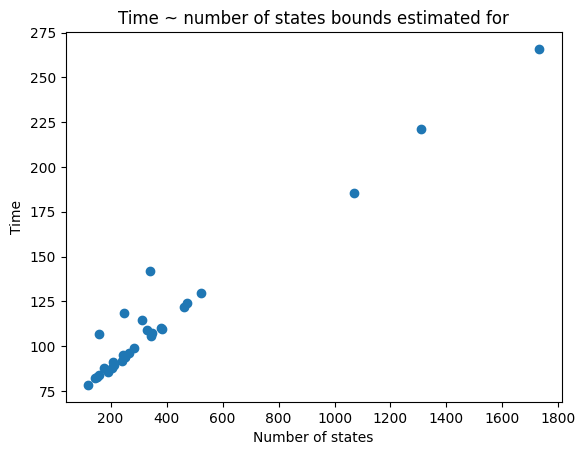

In [108]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_PS.shape[0], size = 30):
    sample = data_PS.iloc[i]
    t, s = bootstrap_time(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

Observed samples take around 10 seconds (if not less) for most samples of < 50 states with a slight linear trend up to ~14 seconds for the samples of ~200 states.

MAP samples with < 400 states take < around 15 seconds, with samples of up to ~1000 states taking up to ~40 seconds. 

However, PS samples are 20 times larger and include the increased number of states as in the MAP samples (and even more). See a linear relationship, with a gradient of ~0.1 (1 more state in the sample increases the time by 0.1 seconds, with a base time of ~75 seconds). These times of up to 5 minutes are too slow.

## New bootstrap code

In [117]:
# sample of states 
sample = [0, 0, 2, 3, 3, 5]
# maximum state observed
x_max = int(np.nanmax(sample))
# add 1 occurance of every state (needed as unique will ignore states that do not appear, messing up order of intervals)
sample += [x for x in range(6)]
# find number of occurances of each state
uni, counts = np.unique(sample, return_counts=True)
# subtract off the 1 added occurance from every state
counts - 1

array([2, 0, 1, 2, 0, 1], dtype=int64)

In [119]:
# sample of states, size n
sample = [0, 0, 2, 3, 3, 5]
# N bootstrap samples as rows in a N x n array
N = 3
n = len(sample)
bootstrap = np.random.choice(sample, size=(N, n))
bootstrap

array([[5, 2, 2, 0, 2, 2],
       [0, 3, 2, 2, 0, 0],
       [5, 0, 2, 0, 0, 3]])

In [147]:
# sample of states, size n
sample = [0, 0, 2, 3, 3, 5]
# maximum state observed
x_max = int(np.nanmax(sample))
# N bootstrap samples as rows in a N x n array
N = 3
n = len(sample)
bootstrap = np.random.choice(sample, size=(N, n))
print(bootstrap)
# append 1 occurance of every state to each row of bootstrap
added = np.repeat(np.arange(x_max + 1), N).reshape(x_max + 1, N).T
bootstrap = np.concatenate((bootstrap, added), axis=1)
print(bootstrap)
# find number of occurances of each state
uni, counts = np.unique(bootstrap, return_counts=True, axis=1)
# subtract off the 1 added occurance from every state
uni, counts

[[0 3 5 5 5 0]
 [0 0 2 0 3 3]
 [5 5 2 3 2 0]]
[[0 3 5 5 5 0 0 1 2 3 4 5]
 [0 0 2 0 3 3 0 1 2 3 4 5]
 [5 5 2 3 2 0 0 1 2 3 4 5]]


(array([[0, 0, 0, 1, 2, 3, 3, 4, 5, 5, 5, 5],
        [0, 0, 3, 1, 2, 0, 3, 4, 0, 2, 3, 5],
        [0, 5, 0, 1, 2, 5, 3, 4, 3, 2, 2, 5]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

Problem is that np.unique is treating the 12 3x1 columns (or 3 1x12 rows) as the values to find counts for so produces a list of 12 1's (as here all columns are unique (appear once each))

### np.bincount

Given a list and a number of bins (minlength sets the minimum number of bins), each bin counts the number of occurances of its index value in the list. 

Could set each row to have x_max + 1 bins to count occurances of states 0, 1, ..., x_max BUT can vectorise: add multiple of x_max + 1 to each row, then can flatten and use N * (x_max + 1) bins to equivalently count states in each row all at once, then reshape occurances to N * (x_max + 1) to give counts of 0, 1, ..., x_max for each of the N rows:

In [152]:
# sample of states, size n
sample = [0, 0, 2, 3, 3, 5]
# maximum state observed
x_max = int(np.nanmax(sample))
# N bootstrap samples as rows in a N x n array
N = 3
n = len(sample)
bootstrap = np.random.choice(sample, size=(N, n))
print(f"Bootstrap samples: \n{bootstrap}")
# offset each row by multiple of x_max + 1
bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
print(f"Offset: \n{bootstrap_offs}")
counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
print(f"Counts: \n{counts}")

Bootstrap samples: 
[[0 3 3 0 0 3]
 [0 0 2 3 0 5]
 [3 0 5 5 5 5]]
Offset: 
[[ 0  3  3  0  0  3]
 [ 6  6  8  9  6 11]
 [15 12 17 17 17 17]]
Counts: 
[[3 0 0 3 0 0]
 [3 0 1 1 0 1]
 [1 0 0 1 0 4]]


In [209]:
# both methods can select nan's
sample = [None, None, 0]
print(random.choices(sample,k=3))
print(np.random.choice(sample, size=3))

[0, None, 0]
[None None None]


In [234]:
# percentiles per column
x = np.array([[0, 0, 0, 9], [1, 1, 1, 10], [2, 2, 2, 11]])
print(x)
y = np.quantile(x, [0.025, 0.975], axis=0)
print(y)
[list(y[:,i]) for i in range(4)]

[[ 0  0  0  9]
 [ 1  1  1 10]
 [ 2  2  2 11]]
[[ 0.05  0.05  0.05  9.05]
 [ 1.95  1.95  1.95 10.95]]


[[0.05, 1.95], [0.05, 1.95], [0.05, 1.95], [9.05, 10.95]]

Implement new method, also changing from x_list to computing all intervals up to maximum state observed in sample

NOTE: in old method missing values (nan's) were resampled and added to length (n) but were not counted. Change to either discarding or replacing by 0

In [8]:
def bootstrap_data_optim(samples, N, plot=False, printing=False, drop_missing=False):
    """
    Bootstrap sample data to find confidence intervals of
    stationary distribution values.

    Inputs:
    samples: sample from stationary distribution (counts of transcripts)
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's
    drop_missing: whether to drop missing values from the sample,
        or replace them with 0 (as used when preparing BayNorm data)

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of all states up to largest observed
    """
    # change to series
    samples = pd.Series(samples)

    # drop missing values
    if drop_missing:
        samples = samples.dropna()
    # replace with 0
    else:
        samples = samples.fillna(value=0.0)

    # change to int
    samples = samples.astype('int64')
    # maximum state observed
    x_max = int(np.nanmax(samples))
    # size of sample
    n = len(samples)

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(samples, size=(N, n))
    # produce N x (x_max + 1) array of counts of states:
    # offset each row by multiple of x_max + 1 for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(x_max + 1)]

    # plot histograms and CI
    for x in range(x_max + 1):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
        if plot:
            plt.hist(counts[:, x] / n)
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[x][0], color="red")
            plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

In [9]:
sample = data_OB.iloc[0]
intervals = bootstrap_data_optim(sample, 1000)

## Almost instant!!!

# Test optimized bootstrap code

In [79]:
def bootstrap_time_optim(sample, N):
    """Time bootstrap for all states in sample, N = bootstrap samples."""
    start = time.time()

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, N)

    # time
    end = time.time()

    # return: time elapsed, number of bounds estimated
    return (end - start, len(intervals))

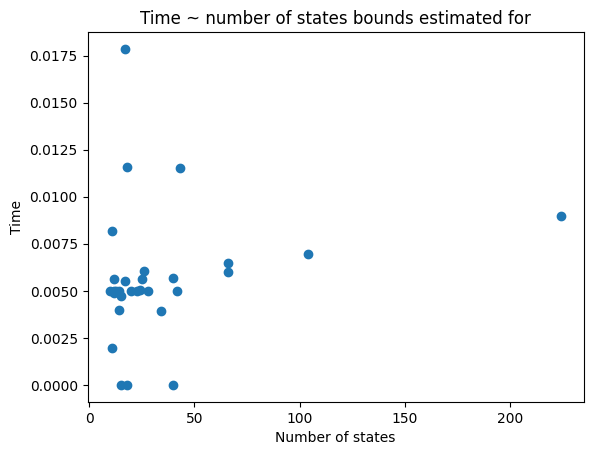

In [95]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_OB.shape[0], size = 30):
    sample = data_OB.iloc[i]
    t, s = bootstrap_time_optim(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

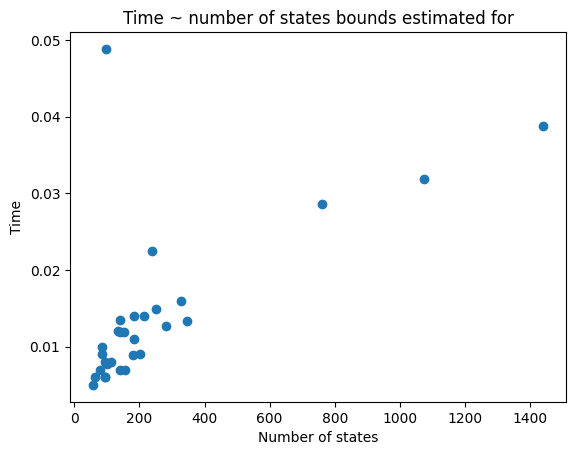

In [248]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_MAP.shape[0], size = 30):
    sample = data_MAP.iloc[i]
    t, s = bootstrap_time_optim(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

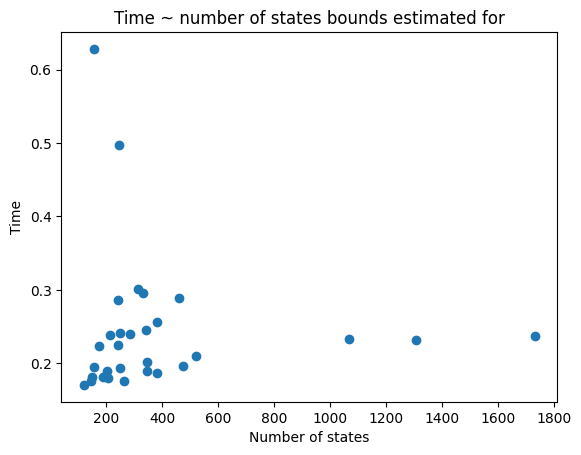

In [249]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_PS.shape[0], size = 30):
    sample = data_PS.iloc[i]
    t, s = bootstrap_time_optim(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

# Compare intervals to check consistent

In [250]:
def CI_analysis_optim(sample, N):
    """
    Given a sample from a (stationary) distribution, create N bootstrap samples
    and estimate confidence intervals for all probabilities in the distribution,
    plot sample and CI's
    """
    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, N)

    # average width (4 d.p)
    avg_width = np.mean([interval[1] - interval[0] for interval in intervals])
    avg_width = float(str(avg_width)[:6])

    # plot sample and CI bounds
    label_dot = "[0, 0] CI"
    label_int = "Confidence interval"
    for i, interval in enumerate(intervals):
        if interval[0] == interval[1]:
            # plot dot for CI of width 0
            plt.plot(i, 0, 'go', label = label_dot)
            # avoid repeated legend
            label_dot = ""
        else:
            plt.plot([i, i], [interval[0], interval[1]], color="red", label = label_int)
            # avoid repeated legend
            label_int = ""
    plt.hist(sample, bins=np.arange(x_max) - 0.5, color="blue", label="Sample", alpha=0.5,
             density=True)
    plt.plot([0,0], label=f"Average bound width = {avg_width}")
    plt.title("Sample and estimated bounds for a gene's transcript count distribution")
    plt.legend()
    plt.show()

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


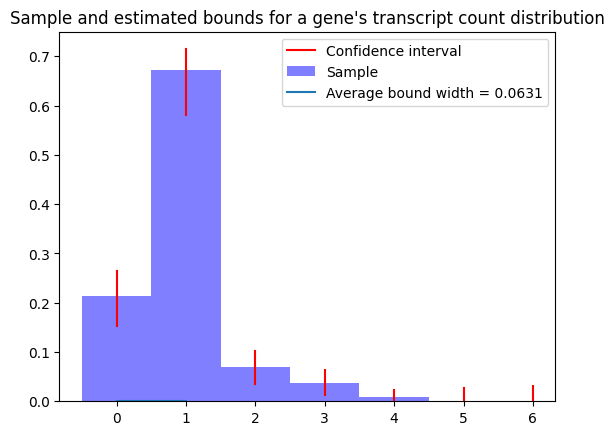

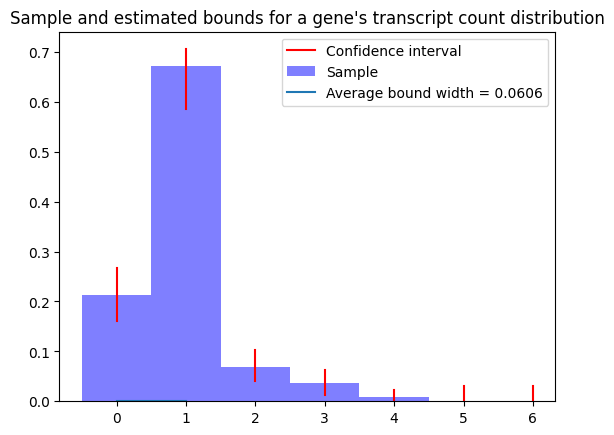

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


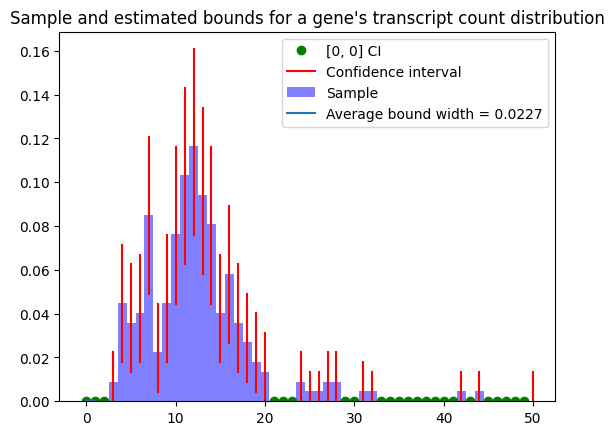

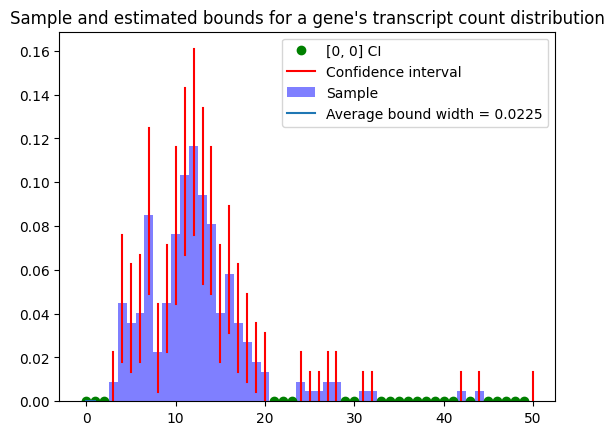

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


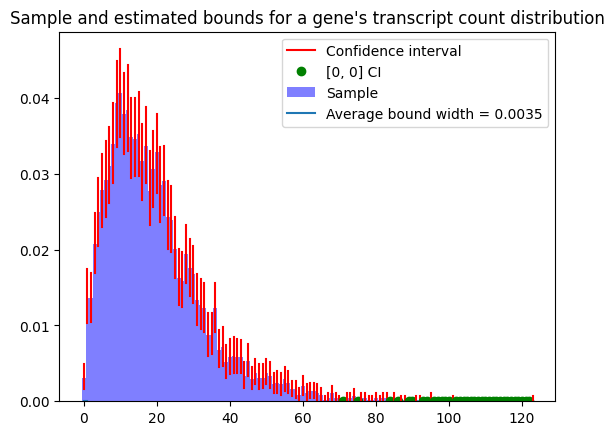

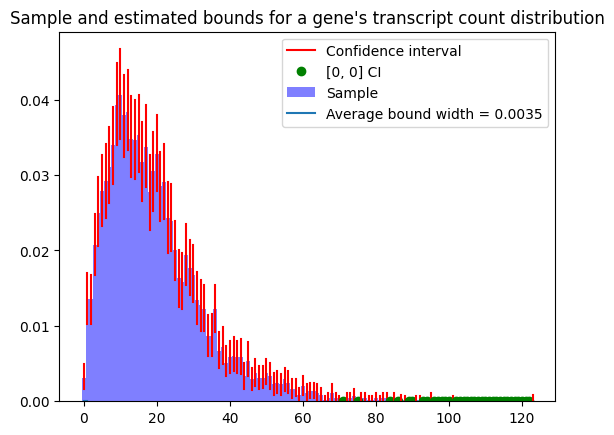

In [251]:
for data in [data_OB, data_MAP, data_PS]:
    sample = data.iloc[1483]
    CI_analysis(sample, 1000)
    CI_analysis_optim(sample, 1000)

Almost identical results (slight differences exepect due to random sampling), dropping/replacing nan values may slightly affect but overall massive speedup with same result.

# Investigate LP solver

Given bounds computed using the new improved bootstrap method now need to time the LP solution process: solving an LP for each variable $k_{0}$, $\pi_{m}$'s, etc to see:
- is the time negligible (i.e. was bootstrapping the issue)
- can a class/parameter objects be used to speed up solving the many programs for a sample that differ only in objective
- do different solvers improve time

NOTE: most up to data pipeline has $\ge$ fix when checking for max-threshold state


In [10]:
def bursty_LP(N, intervals, k0=None, k1=None, M=None):
    """
    Solve bursty LP system to get interval bounds on parameters.

    Inputs:
    N: number of rows of Q / number of equations used
    M: maximum burst size to consider (>= 1)
    intervals: confidence intervals for at least N + 1 states

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # if max burst not specified: set to the largest burst that appears in Qp = 0 constraint
    if not M:
        M = N - 1

    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # bounds from CI
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate to N + 1 values as using up to Nth equation
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # Construct the problem

    # Variables: specify k1 or k0 manually
    if not k0:
        k0 = cv.Variable()
    if not k1:
        k1 = cv.Variable(1)
    mu = cv.Variable(M)
    z0 = cv.Variable(N + 1)
    z1 = cv.Variable(N + 1)
    y = cv.Variable((N + 1, M))

    # constraints
    constraints = [
        Q1 @ z1 + Q00 @ z0 + sum([Q0(m + 1) @ y[:, m] for m in range(0, M)]) == 0,
        k0 >= 0, k1 >= 0, mu >= 0, z0 >= 0, z1 >= 0, y >= 0,
        k0 * pl <= z0, z0 <= k0 * pu,
        k1 * pl <= z1, z1 <= k1 * pu,
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([mu[m] for m in range(0, M)]) <= k0,
        # dist. const.
        sum([z0[x] for x in range(N + 1)]) <= k0,
        sum([z1[x] for x in range(N + 1)]) <= k1
    ]
    for m in range(0, M):
        constraints +=  [
            mu[m] * pl <= y[:, m], y[:, m] <= mu[m] * pu,
            # dist. const.
            sum([y[x, m] for x in range(N + 1)]) <= mu[m]
        ]

    # solution interval dict
    solutions = {}

    # solver function
    def solver(dict_name, var, solutions):
        # create inteval
        solutions[dict_name] = []
        # min and max objectives
        objective_min = cv.Minimize(var)
        objective_max = cv.Maximize(var)
        # min and max problems
        prob_min = cv.Problem(objective_min, constraints)
        prob_max = cv.Problem(objective_max, constraints)   
        # solve min: add to solution
        result_min = prob_min.solve()#verbose=True)
        try:
            solutions[dict_name].append(var.value.item())
        except:
            solutions[dict_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve()#verbose=True)
        try:
            solutions[dict_name].append(var.value.item())
        except:
            solutions[dict_name].append(None)
        # add statuses
        solutions[dict_name].append(prob_min.status)
        solutions[dict_name].append(prob_max.status)

    # solve for k0
    if type(k0) == int:
        solutions['k0'] = k0
    else:
        solver('k0', k0, solutions)

    # solve for k1
    if type(k1) == int:
        solutions['k1'] = k1
    else:
        solver('k1', k1, solutions)

    # solve for mu_1, mu_2, ..., mu_M
    for m in range(0, M):
        solver(f'mu_{m + 1}', mu[m], solutions)

    return solutions

In [11]:
def bound_sample_refined(sample, threshold=5, skip=1, n=1000, N=None, 
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True):
    """
    Given transcript samples from gene, bootstrap and solve LP to bound parameters

    sample: list of up to ~200 counts of transcripts of gene in cells
    threshold: minimum number of occurances in sample needed to include state x
            set to zero to use up to max state available
    skip: number of equations to drop after an infeasible result
    n: number of bootstrap samples
    N: option to manually specify number of equations used
    settings:
    plot_sample: toggle histogram of sample
    print_bounds: toggle printing CI bounds
    print_status: toggle printing feasible/infeasible reports
    plot_solution: toggle plotting solution bounds on distribution
    """

    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    s1 = time.time()
    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, n, printing=print_bounds)
    e1 = time.time()
    print(f"Bootstrap: {e1 - s1}")

    s2 = time.time()
    # dict of states and occurances in sample
    counts = sample.value_counts().to_dict()

    # find max state with more than threshold occurances
    x_max_thresh = x_max
    # look at all states: decreasing from max
    for x in range(x_max, -1, -1):
        if x in counts:
            # check for first state with >= threshold occurances
            if counts[x] >= threshold:
                # record state
                x_max_thresh = x
                break

    # edge case: need at least bounds up to p(2) to estimate pi_1
    if x_max_thresh < 2:
        print("Edge case")
        x_max_thresh = 2

    # for each state up to x_max_thesh:
    # above threshold # observations => use CI
    # below => use [0,1] bounds
    # track [0,1] bounded states
    non_bounds = []
    for x in range(x_max_thresh + 1):
        if x in counts:
            # below
            if counts[x] < threshold:
                # [0,1] bounds
                intervals[x] = np.array([0.0, 1.0])
                non_bounds.append(x)
        # if not in count: 0 occurances, below threshold (unless = 0)
        elif threshold > 0:
            intervals[x] = np.array([0.0, 1.0])
            non_bounds.append(x)
    e2 = time.time()
    print(f"Bounds: {e2 - s2}")
     
    # plot sample hist and threshold
    if plot_sample:
        plt.hist(sample, bins=x_max);
        plt.title("Histogram of transcript counts for given gene")
        plt.axhline(threshold, 0, 1, color="orange", label=f"threshold {threshold}")
        plt.axvline(x_max, color="red", label=f"Max state {x_max}")
        plt.axvline(x_max_thresh, color="red", label=f"Max threshold state {x_max_thresh}")
        for x in non_bounds:
            plt.axvline(x, color="green")
        plt.legend()
        plt.show()

    # get bounds on p(0), ..., p(x_max_thresh)
    # can use UP TO equation N = x_max, as involves up to p(x_max_thresh)
    # equation N involves pi's up to pi_(N-1), so M = N - 1
    if not N:
        N = x_max_thresh
    M = N - 1
    
    s3 = time.time()
    # solve LP using data
    solutions_dist = bursty_LP(N, intervals, k0=1)
    e3 = time.time()
    print(f"LP: {e3 - s3}")

    s4 = time.time()
    # check if infeasible
    while solutions_dist['mu_1'][2] == 'infeasible':
        if print_status: print(f"N = {N} infeasible")
        # stop if too few equations (cannot reduce any further leads to M = 0)
        if N <= skip + 1:
            break
        # try again with smaller N (drop 'skip' # of equations)
        N -= skip
        M -= skip
        solutions_dist = bursty_LP(N, intervals, k0=1)

    if print_status: print(f"N = {N} feasible:")
    e4 = time.time()
    print(f"reduction to feasible: {e4 - s4}")

    # plot
    if plot_solution:
        # extract distribution bounds
        labels = [f'mu_{m}' for m in range(1, M + 1)]
        lower = [solutions_dist[var][0] for var in labels]
        upper = [solutions_dist[var][1] for var in labels]
        plt.plot(labels, upper, label = "Upper bound")
        plt.plot(labels, lower, label = "Lower bound")
        plt.title("LP Bounds on birth distribution")
        plt.ylabel("Probability")
        plt.xlabel("Birth distribution")
        plt.legend()
        plt.show()

    # return bounds
    return solutions_dist

## Timing

Bootstrap: 0.17267537117004395
Bounds: 0.0009868144989013672


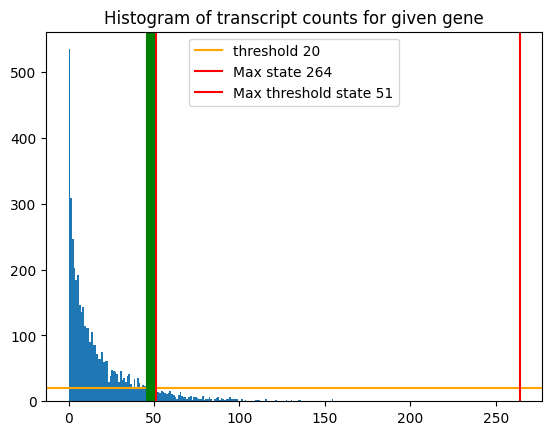

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 25.34354853630066
N = 51 infeasible
N = 50 infeasible
N = 49 infeasible
N = 48 infeasible
N = 47 infeasible
N = 46 infeasible
N = 45 infeasible
N = 44 infeasible
N = 43 infeasible
N = 42 infeasible
N = 41 infeasible
N = 40 infeasible
N = 39 infeasible
N = 38 infeasible
N = 37 infeasible
N = 36 infeasible
N = 35 infeasible
N = 34 infeasible
N = 33 infeasible
N = 32 infeasible
N = 31 infeasible
N = 30 infeasible
N = 29 feasible:
reduction to feasible: 274.71761441230774


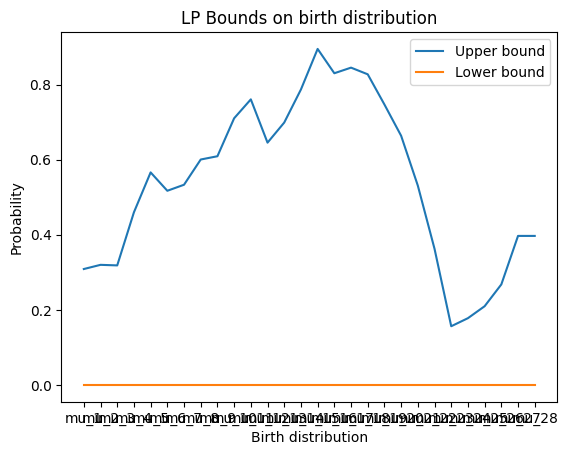

Bootstrap: 0.17763972282409668
Bounds: 0.0010042190551757812


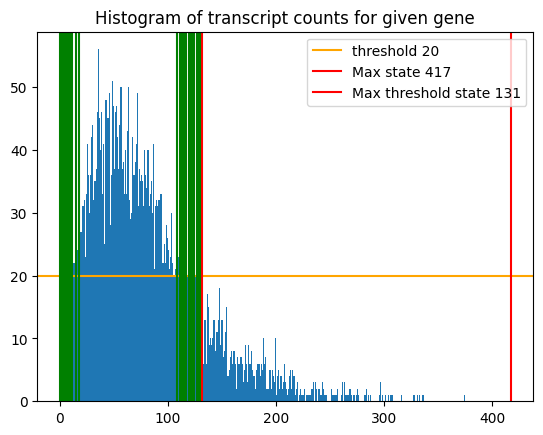

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


LP: 621.8280336856842
N = 131 feasible:
reduction to feasible: 0.0


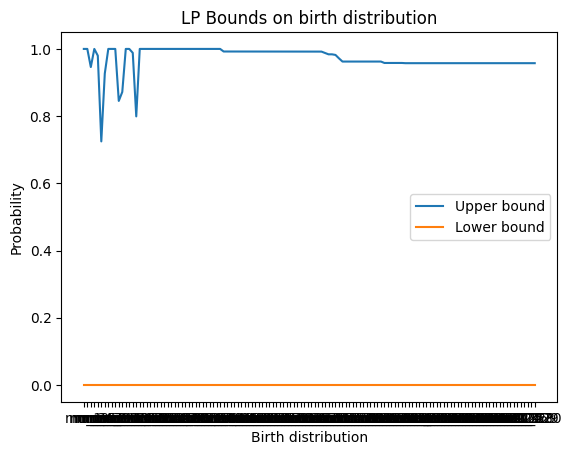

Bootstrap: 0.16809725761413574
Bounds: 0.0009984970092773438


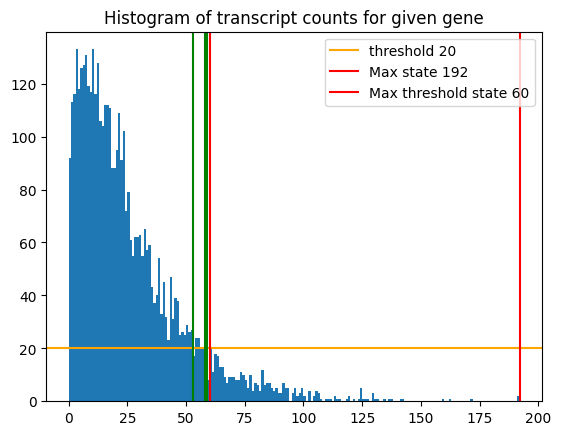

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 39.721723794937134
N = 60 infeasible
N = 59 infeasible
N = 58 infeasible
N = 57 infeasible
N = 56 infeasible
N = 55 infeasible
N = 54 infeasible
N = 53 infeasible
N = 52 infeasible
N = 51 infeasible
N = 50 infeasible
N = 49 infeasible
N = 48 infeasible
N = 47 infeasible
N = 46 infeasible
N = 45 infeasible
N = 44 infeasible
N = 43 infeasible
N = 42 feasible:
reduction to feasible: 392.1552677154541


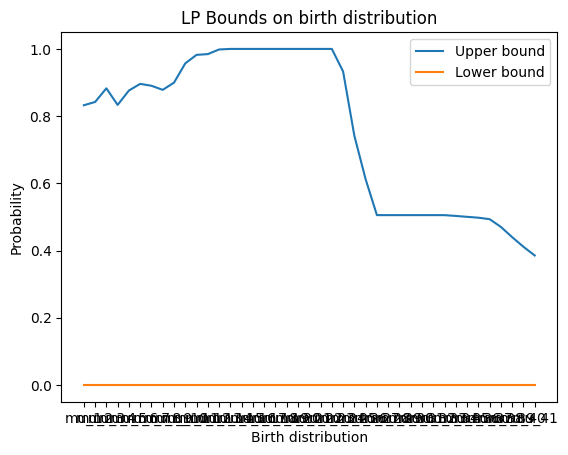

In [262]:
rng = np.random.default_rng(44)
for i in rng.choice(data_PS.shape[0], size = 3):
    sample = data_PS.iloc[i]
    sol = bound_sample_refined(sample, threshold=20)

The bootstrap and state selection are now very fast, but solving the multiple LP's (espcially when dropping equations and re-solving until feasible) still takes far too long for the large posterior sample data.

# Sensitivity analysis: warm start using parameters

Sensitivity analysis for linear programs looks at how the solution changes when coefficient in the constraints or objective function are varied. In many cases the previous solution can be used, either directily or as a better starting point, to solve the new problem faster, rather than starting from scratch.

Cvxpy has Parameter objects that can be used when defining Program objects: changing the value of a parameter and re-solving the program, cvxpy will use a 'warm start': using sensitivity analysis to speed up solutions.

In [278]:
# create LP

# variables
x = cv.Variable()
y = cv.Variable()

# constraints
constraints = [
    2 * x + y <= 1,
    x + 2 * y <= 1
]

# objective
lam = cv.Parameter(2)
objective = cv.Maximize(lam @ cv.vstack([x, y]))

# Program
prob = cv.Problem(objective, constraints)

# set parameter value
lam.value = [1, 1]

# solve
s1 = time.time()
answer = prob.solve()
e1 = time.time()
print(f"Value: {prob.value}, x = {x.value}, y = {y.value}")
print(f"Time = {e1 - s1}")

# change parameter value
lam.value = [2, 2]

# re-solve
s2 = time.time()
answer = prob.solve(warm_start=True)
e2 = time.time()
print(f"Value: {prob.value}, x = {x.value}, y = {y.value}")
print(f"Time = {e2 - s2}")

Value: 0.6666666663102279, x = 0.33333333315511393, y = 0.33333333315511393
Time = 0.021942138671875
Value: 1.3333333329802692, x = 0.3333333332450673, y = 0.33333333324506736
Time = 0.0025162696838378906


See that even in this very simple example, changing the parameter value of an existing problem and using a warm start significantly reduces the time taken to solve the LP again.

## Modify LP solver

In [12]:
def bursty_LP_optim(N, intervals, k0=None, k1=None, M=None):
    """
    Solve bursty LP system to get interval bounds on parameters.

    Inputs:
    N: number of rows of Q / number of equations used
    M: maximum burst size to consider (>= 1)
    intervals: confidence intervals for at least N + 1 states

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # if max burst not specified: set to the largest burst that appears in Qp = 0 constraint
    if not M:
        M = N - 1

    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # bounds from CI
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate to N + 1 values as using up to Nth equation
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # Construct the problem

    # Variables: specify k1 or k0 manually
    if not k0:
        k0 = cv.Variable()
    if not k1:
        k1 = cv.Variable()
    mu = cv.Variable(M)
    z0 = cv.Variable(N + 1)
    z1 = cv.Variable(N + 1)
    y = cv.Variable((N + 1, M))

    # constraints
    constraints = [
        Q1 @ z1 + Q00 @ z0 + sum([Q0(m + 1) @ y[:, m] for m in range(0, M)]) == 0,
        k0 >= 0, k1 >= 0, mu >= 0, z0 >= 0, z1 >= 0, y >= 0,
        k0 * pl <= z0, z0 <= k0 * pu,
        k1 * pl <= z1, z1 <= k1 * pu,
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([mu[m] for m in range(0, M)]) <= k0,
        # dist. const.
        sum([z0[x] for x in range(N + 1)]) <= k0,
        sum([z1[x] for x in range(N + 1)]) <= k1
    ]
    for m in range(0, M):
        constraints +=  [
            mu[m] * pl <= y[:, m], y[:, m] <= mu[m] * pu,
            # dist. const.
            sum([y[x, m] for x in range(N + 1)]) <= mu[m]
        ]

    # Objective
    c = cv.Parameter(M)
    objective = c @ mu
    objective_min = cv.Minimize(objective)
    objective_max = cv.Maximize(objective)

    # solution interval dict
    solutions = {}

    # values of c parameter: e_1, ..., e_M+2
    c_values = [[1 if i == j else 0 for j in range(M)] for i in range(M)]

    # create problem
    prob_min = cv.Problem(objective_min, constraints)
    prob_max = cv.Problem(objective_max, constraints)

    # variable names
    var_names = [f"mu_{m + 1}" for m in range(M)]

    # repeatedly solve
    for i, c_val in enumerate(c_values):
        # variable
        var_name = var_names[i]
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = c_val
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    
    return solutions

In [13]:
def bound_sample_refined_optim(sample, threshold=5, skip=1, n=1000, N=None, 
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True):
    """
    Given transcript samples from gene, bootstrap and solve LP to bound parameters

    sample: list of up to ~200 counts of transcripts of gene in cells
    threshold: minimum number of occurances in sample needed to include state x
            set to zero to use up to max state available
    skip: number of equations to drop after an infeasible result
    n: number of bootstrap samples
    N: option to manually specify number of equations used
    settings:
    plot_sample: toggle histogram of sample
    print_bounds: toggle printing CI bounds
    print_status: toggle printing feasible/infeasible reports
    plot_solution: toggle plotting solution bounds on distribution
    """

    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    s1 = time.time()
    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, n, printing=print_bounds)
    e1 = time.time()
    print(f"Bootstrap: {e1 - s1}")

    s2 = time.time()
    # dict of states and occurances in sample
    counts = sample.value_counts().to_dict()

    # find max state with more than threshold occurances
    x_max_thresh = x_max
    # look at all states: decreasing from max
    for x in range(x_max, -1, -1):
        if x in counts:
            # check for first state with >= threshold occurances
            if counts[x] >= threshold:
                # record state
                x_max_thresh = x
                break

    # edge case: need at least bounds up to p(2) to estimate pi_1
    if x_max_thresh < 2:
        print("Edge case")
        x_max_thresh = 2

    # for each state up to x_max_thesh:
    # above threshold # observations => use CI
    # below => use [0,1] bounds
    # track [0,1] bounded states
    non_bounds = []
    for x in range(x_max_thresh + 1):
        if x in counts:
            # below
            if counts[x] < threshold:
                # [0,1] bounds
                intervals[x] = np.array([0.0, 1.0])
                non_bounds.append(x)
        # if not in count: 0 occurances, below threshold (unless = 0)
        elif threshold > 0:
            intervals[x] = np.array([0.0, 1.0])
            non_bounds.append(x)
    e2 = time.time()
    print(f"Bounds: {e2 - s2}")
     
    # plot sample hist and threshold
    if plot_sample:
        plt.hist(sample, bins=x_max);
        plt.title("Histogram of transcript counts for given gene")
        plt.axhline(threshold, 0, 1, color="orange", label=f"threshold {threshold}")
        plt.axvline(x_max, color="red", label=f"Max state {x_max}")
        plt.axvline(x_max_thresh, color="red", label=f"Max threshold state {x_max_thresh}")
        for x in non_bounds:
            plt.axvline(x, color="green")
        plt.legend()
        plt.show()

    # get bounds on p(0), ..., p(x_max_thresh)
    # can use UP TO equation N = x_max, as involves up to p(x_max_thresh)
    # equation N involves pi's up to pi_(N-1), so M = N - 1
    if not N:
        N = x_max_thresh
    M = N - 1
    
    s3 = time.time()
    # solve LP using data
    solutions_dist = bursty_LP_optim(N, intervals, k0=1)
    e3 = time.time()
    print(f"LP: {e3 - s3}")

    s4 = time.time()
    # check if infeasible
    while solutions_dist['mu_1'][2] == 'infeasible':
        if print_status: print(f"N = {N} infeasible")
        # stop if too few equations (cannot reduce any further leads to M = 0)
        if N <= skip + 1:
            break
        # try again with smaller N (drop 'skip' # of equations)
        N -= skip
        M -= skip
        solutions_dist = bursty_LP_optim(N, intervals, k0=1)

    if print_status: print(f"N = {N} feasible:")
    e4 = time.time()
    print(f"reduction to feasible: {e4 - s4}")

    # plot
    if plot_solution:
        # extract distribution bounds
        labels = [f'mu_{m}' for m in range(1, M + 1)]
        lower = [solutions_dist[var][0] for var in labels]
        upper = [solutions_dist[var][1] for var in labels]
        plt.plot(labels, upper, label = "Upper bound")
        plt.plot(labels, lower, label = "Lower bound")
        plt.title("LP Bounds on birth distribution")
        plt.ylabel("Probability")
        plt.xlabel("Birth distribution")
        plt.legend()
        plt.show()

    # return bounds
    return solutions_dist

### Test

Bootstrap: 0.2180805206298828
Bounds: 0.00356292724609375


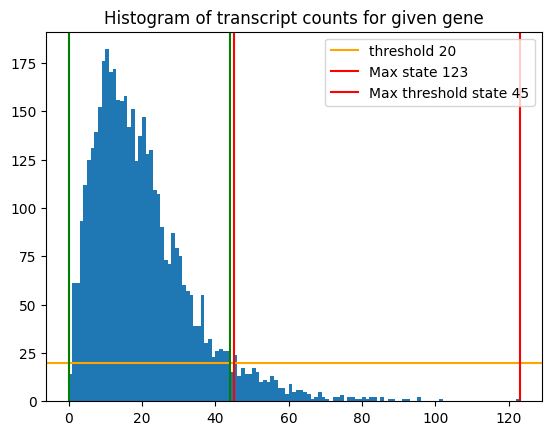

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 7.110430717468262
N = 45 feasible:
reduction to feasible: 0.0


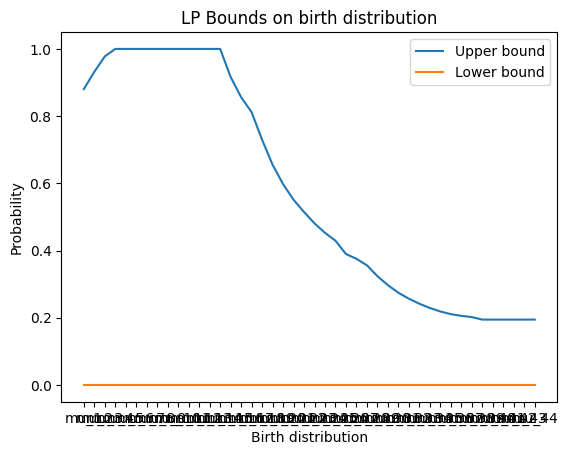

Bootstrap: 0.1949148178100586
Bounds: 0.0010097026824951172


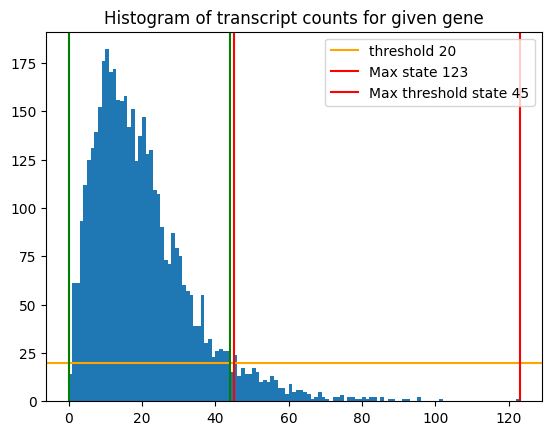

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 19.15263319015503
N = 45 feasible:
reduction to feasible: 0.0


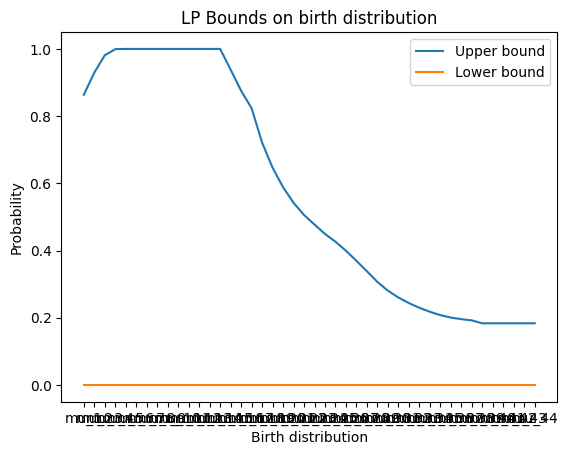

In [15]:
sample = data_PS.iloc[1483]
sol_new = bound_sample_refined_optim(sample, threshold=20)
sol__old = bound_sample_refined(sample, threshold=20)

# Upscaling within the model

By using BayNorm to upscale entire datasets of observed counts into true counts, the increased number of states and samples causes computational difficulties and can be hard to work with.

Instead, we can use capture efficiencies $ \beta $, estimated using BayNorm, and the stationary distribution of observed counts $ p_{obs} $, estimated from observed data, to compute the stationary distribution of true counts $ p $. This is done by using the binomial scaling matrix as described in notes.

Implementing this method we can then compare:
- bootstrapping observed data and using $ \beta $ to upscale to $ p $ (as above)
- upscaling dataset using BayNorm, then bootstrapping to get $ p $ (as before)

In [14]:
# List of Beta_j values for each cell j (named)
beta = pd.read_csv("..\Data\SS3_c57_UMIs_concat_BETA.csv", index_col="Unnamed: 0")
beta.head()

,x
SS3_MAF_Leo171129_p2_S10,0.056771
SS3_MAF_Leo171129_p2_S12,0.074493
SS3_MAF_Leo171129_p2_S13,0.068636
SS3_MAF_Leo171129_p2_S14,0.061267
SS3_MAF_Leo171129_p2_S16,0.059506


In [15]:
def B_matrix(beta, x_max, x_max_0):
    """
    Construct the binomial upscaling matrix B

    Arguments:
    beta: capture efficiencies for each cell
    x_max: observed truncation T = {0, ... , x_max}
    x_max_0: 'true' truncation T_0 = {0, ..., x_max_0}

    Returns:
    B: |T| x |T_0| upscaling matrix (x_max + 1, x_max_0 + 1)
    """
    if type(beta) == pd.core.frame.DataFrame:
        beta_list = list(beta['x'])
    elif type(beta) == float:
        beta_list = [beta]
    else:
        beta_list = beta

    # initialise B
    B = np.zeros((x_max + 1, x_max_0 + 1))
    # loop over beta_j values
    for beta_j in beta_list:
        # create B_j matrix
        f = lambda x, x0: scipy.special.comb(x0, x) * beta_j**x * (1 - beta_j)**(x0 - x)
        B_j = np.fromfunction(f, (x_max + 1, x_max_0 + 1))
        # add to B
        B += B_j
    # scale B
    B = B / len(beta_list)
    return B

In [16]:
B_matrix(beta, 3, 3)

array([[1.00000000e+00, 9.40000000e-01, 8.84734714e-01, 8.33743327e-01],
       [0.00000000e+00, 6.00000000e-02, 1.10530571e-01, 1.52974163e-01],
       [0.00000000e+00, 0.00000000e+00, 4.73471434e-03, 1.28216943e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.60816246e-04]])

## Eaxmple

Select a gene from the dataset of observed counts, bootstrap to estimate the observed stationary distribution, compute B and then find $ p = B^{-1}p_{obs} $

In [17]:
# select gene from observed counts
sample_obs = data_OB.iloc[1]
print("Bounds on observed data:")
intervals_obs = bootstrap_data_optim(sample_obs, 1000, printing=True)

# find x_max: intervals are for p(0), ..., p(x_max)
x_max = len(intervals_obs) - 1

# optionally reduce the number of bounds considered
x_max = 2

# compute p_L and p_U arrays
pl_obs = np.array([intr[0] for intr in intervals_obs])[:x_max + 1]
pu_obs = np.array([intr[1] for intr in intervals_obs])[:x_max + 1]

# set x_max_0 = x_max (square B for inversion)
x_max_0 = x_max

# compute B matrix
B = B_matrix(beta, x_max, x_max_0)

print(f"\nB = \n{B}")

print(f"\nCondition number of B: {np.linalg.cond(B)}")

print(f"\n Det(B) = {np.linalg.det(B)}")

# invert B
Binv = np.linalg.inv(B)

U,s,V = np.linalg.svd(B)
Binv_svd = np.transpose(V) @ np.diag(1/s) @ np.transpose(U)

print(f"\nB^-1 = \n{Binv}")

print(f"\nB^-1 using SVD = \n{Binv_svd}")

# compute bounds on true distribution
# pl_true = Binv_svd @ pl_obs
# pu_true = Binv_svd @ pu_obs

pl_true = np.linalg.solve(B, pl_obs)
pu_true = np.linalg.solve(B, pu_obs)

print(f"\nResult of B @ (Binv @ p_obs) [should match first bounds]:")
print(B @ pl_true)
print(B @ pu_true)

# print
print(f"\nUpscaled bounds on true data")
pl_true, pu_true

Bounds on observed data:
95% CI for p(0) is: (0.16517857142857142, 0.27232142857142855)
95% CI for p(1) is: (0.06696428571428571, 0.14285714285714285)
95% CI for p(2) is: (0.08928571428571429, 0.17857142857142858)
95% CI for p(3) is: (0.08035714285714286, 0.16529017857142847)
95% CI for p(4) is: (0.06696428571428571, 0.14285714285714285)
95% CI for p(5) is: (0.03125, 0.09375)
95% CI for p(6) is: (0.04017857142857143, 0.10714285714285714)
95% CI for p(7) is: (0.008928571428571428, 0.049107142857142856)
95% CI for p(8) is: (0.017857142857142856, 0.06696428571428571)
95% CI for p(9) is: (0.022321428571428572, 0.07589285714285714)
95% CI for p(10) is: (0.008928571428571428, 0.049107142857142856)
95% CI for p(11) is: (0.0, 0.03125)
95% CI for p(12) is: (0.0, 0.013392857142857142)
95% CI for p(13) is: (0.0, 0.013392857142857142)
95% CI for p(14) is: (0.0, 0.022321428571428572)
95% CI for p(15) is: (0.0, 0.0)
95% CI for p(16) is: (0.0, 0.0)
95% CI for p(17) is: (0.0, 0.013392857142857142)
95%

(array([ 15.08684381, -33.62309237,  18.85767714]),
 array([ 29.97577095, -67.09737522,  37.71535428]))

However, see that the condition number of B is very large even for small number of states (and huge for larger numbers), so it is not feasible to invert B to produce bounds on $ p $.

Instead, we consider the other direction to compare:
- select a gene
- using MAP/PS upscaled datasets bootstrap estimates for $ p $
- compute B
- downscale to compute $ p_{obs} = Bp $
- compare to $ p_{obs} $ computed directly from observed data using bootstrap

In [54]:
# select gene from upscaled counts (MAP)
sample_MAP = data_MAP.iloc[0]
intervals_MAP = bootstrap_data_optim(sample_MAP, 1000)

# find x_max_0: intervals are for p(0), ..., p(x_max_0)
x_max_0 = len(intervals_MAP) - 1

# optionally reduce the number of bounds considered
# x_max_0 = 1

# compute p_L and p_U arrays
pl_MAP = np.array([intr[0] for intr in intervals_MAP])[:x_max_0 + 1]
pu_MAP = np.array([intr[1] for intr in intervals_MAP])[:x_max_0 + 1]

# set x_max = x_max_0
x_max = x_max_0

# compute B matrix
B = B_matrix(beta, x_max, x_max_0)

# compute bounds on observed distribution
pl_downscaled_MAP = B @ pl_MAP
pu_downscaled_MAP = B @ pu_MAP

# first 5 entries
pl_downscaled_MAP[0:5], pu_downscaled_MAP[0:5]

(array([0.17599387, 0.04352236, 0.01903849, 0.01010342, 0.00512411]),
 array([0.76314746, 0.41808229, 0.27856569, 0.1859707 , 0.12369308]))

## Compare

Compute estimates of observed stationary distribution for the same gene by simply bootstrapping the observed data, compare:

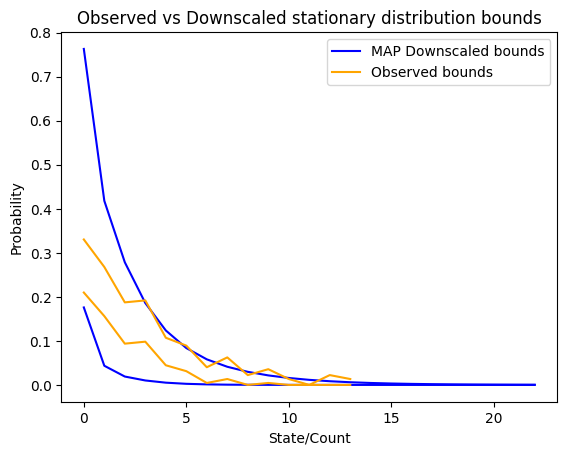

In [55]:
# select gene from observed counts
sample_obs = data_OB.iloc[0]
intervals_obs = bootstrap_data_optim(sample_obs, 1000)

# largest bound estimated
x_max = len(intervals_obs) - 1

# compute p_L and p_U arrays: reduce in size
pl_obs = np.array([intr[0] for intr in intervals_obs])[:x_max + 1]
pu_obs = np.array([intr[1] for intr in intervals_obs])[:x_max + 1]

#plot: reduce size of Downscaled arrays
plt.plot(pl_downscaled_MAP[:x_max + 10], label="MAP Downscaled bounds", color="blue")
plt.plot(pu_downscaled_MAP[:x_max + 10], color="blue")
plt.plot(pl_obs, label="Observed bounds", color="orange")
plt.plot(pu_obs, color="orange")
plt.xlabel("State/Count")
plt.ylabel("Probability")
plt.title("Observed vs Downscaled stationary distribution bounds")
plt.legend()
plt.show()

In [57]:
# select gene from upscaled counts (PS)
sample_PS = data_PS.iloc[0]
intervals_PS = bootstrap_data_optim(sample_PS, 1000)

# find x_max_0: intervals are for p(0), ..., p(x_max_0)
x_max_0 = len(intervals_PS) - 1

# optionally reduce the number of bounds considered
# x_max_0 = 1

# compute p_L and p_U arrays
pl_PS = np.array([intr[0] for intr in intervals_PS])[:x_max_0 + 1]
pu_PS = np.array([intr[1] for intr in intervals_PS])[:x_max_0 + 1]

# set x_max = x_max
x_max = x_max_0

# compute B matrix
B = B_matrix(beta, x_max, x_max_0)

# compute bounds on observed distribution
pl_downscaled_PS = B @ pl_PS
pu_downscaled_PS = B @ pu_PS

# first 5 entries
pl_downscaled_PS[0:5], pu_downscaled_PS[0:5]

(array([0.22712348, 0.15402063, 0.10055048, 0.06575833, 0.04335211]),
 array([0.37721366, 0.2698974 , 0.18840237, 0.13279624, 0.09516967]))

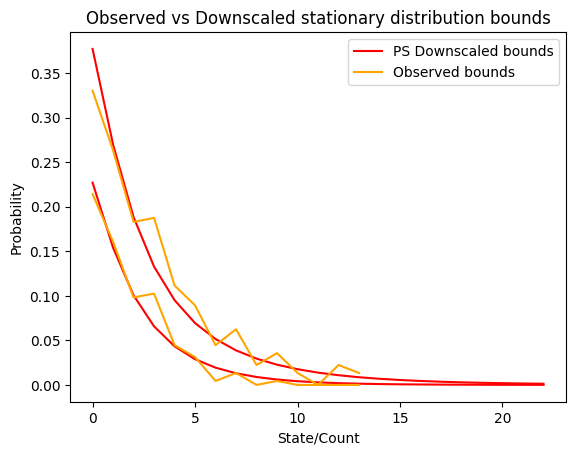

In [58]:
# select gene from observed counts
sample_obs = data_OB.iloc[0]
intervals_obs = bootstrap_data_optim(sample_obs, 1000)

# largest bound estimated
x_max = len(intervals_obs) - 1

# compute p_L and p_U arrays: reduce in size
pl_obs = np.array([intr[0] for intr in intervals_obs])[:x_max + 1]
pu_obs = np.array([intr[1] for intr in intervals_obs])[:x_max + 1]

#plot: reduce size of Downscaled arrays
plt.plot(pl_downscaled_PS[:x_max + 10], label="PS Downscaled bounds", color="red")
plt.plot(pu_downscaled_PS[:x_max + 10], color="red")
plt.plot(pl_obs, label="Observed bounds", color="orange")
plt.plot(pu_obs, color="orange")
plt.xlabel("State/Count")
plt.ylabel("Probability")
plt.title("Observed vs Downscaled stationary distribution bounds")
plt.legend()
plt.show()

# Including B in the LP

Now implement upscaling within the LP: given confidence intervals for the stationary distribution of observed counts: $ p_{L} \le p_{obs} \le p_{U} $ (computed via bootstrap), we compute an upscaling matrix B (of suitable size) s.t. $ p_{obs} = Bp $.

However, since we cannot work with infinite dimensional B and p we truncate to states {0, .., x_max_0} and so cannot directly use the bounds $ p_{L} \le B p \le p_{U} $ as we need to consider the truncation error:

$$ p_{L} - \frac{E[X^{0}]}{x_{max_0} + 1} \le B p \le p_{U} $$

To compute the mean true count $ E[X^{0}] $, we estimate the mean observed count $ E[X] $ from the sample and then use:

$$ E[X^{0}] = \frac{E[X]}{<\beta>} $$

Where $ <\beta> $ is the mean capture efficiency for cells in the sample, usually fixed to 0.06. We then work with the stationary distribution of true counts $ p $ (or $z_{k}$'s for linearity) in the model.

## Estimating E[X]

To bound the truncation error we need a value for the mean observed count. Taking the sample mean as a point estimate can lead to infeasibility (the variance could lead the bound to be false), so instead we find a 95% CI for the mean and use the upper bound to give a lower bound on Bp:

$$ p_{L} - \frac{E[X]^{U}}{<\beta>(x_{max_0} + 1)} \le B p $$

In [18]:
def mean_CI(sample):
    '''Compute 95% confidence interval for the mean of the sample.'''
    # sample mean
    mean = np.mean(sample)
    # sample standard deviation
    std = np.std(sample)
    # size of the sample
    n = len(sample)
    # compute CI
    return (mean - 1.96 * (std / np.sqrt(n)), mean + 1.96 * (std / np.sqrt(n)))

In [19]:
sample = data_OB.iloc[0]
mean_CI(sample)

(2.036987142228961, 2.696044531979184)

In [20]:
def bursty_LP_B(intervals, x_max, x_max_0, mean_true_ub, k0=None, k1=None, M=None):
    """
    Solve the butsty LP system for interval bounds on parameters,
    upscaling observed data into true count data using B matrix

    Inputs:
    intervals: confidence intervals on observed count stationary distribution
    x_max: use observed bounds p(0), ..., p(x_max)
    x_max_0: use upscaled bounds p(0), ..., p(x_max_0)
    mean_true_ub: upper bound on expected value of upscaled counts E[X^0]
    k0, k1: fixed values of parameters

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # observed bounds from CI
    pl_obs = [intr[0] for intr in intervals]
    pu_obs = [intr[1] for intr in intervals]

    # select observed bounds on p(0), ..., p(x_max)
    pl_obs = np.array(pl_obs)[:x_max + 1]
    pu_obs = np.array(pu_obs)[:x_max + 1]

    # compute upscaling B matrix
    B = B_matrix(beta, x_max, x_max_0)

    # number of equations N = x_max_0
    N = x_max_0

    # compute uppper bound on truncation error
    t_bound = mean_true_ub / (x_max_0 + 1)

    # estikmate up to largest burst size (unless otherwise specified)
    if not M:
        M = N - 1
    
    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # Construct the problem

    # Variables: unless k0 or k1 are fixed
    if not k0:
        k0 = cv.Variable()
    if not k1:
        k1 = cv.Variable()
    mu = cv.Variable(M)
    z0 = cv.Variable(N + 1)
    z1 = cv.Variable(N + 1)
    y = cv.Variable((N + 1, M))

    # constraints
    constraints = [
        # Qp = 0
        Q1 @ z1 + Q00 @ z0 + sum([Q0(m + 1) @ y[:, m] for m in range(0, M)]) == 0,
        # non-neg
        k0 >= 0, k1 >= 0, mu >= 0, z0 >= 0, z1 >= 0, y >= 0,
        # upscaled observed bounds
        k0 * pl_obs - k0 * t_bound <= B @ z0, B @ z0 <= k0 * pu_obs,
        k1 * pl_obs - k1 * t_bound <= B @ z1, B @ z1 <= k1 * pu_obs,
        # burst distribution constraints
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([mu[m] for m in range(0, M)]) <= k0,
        # dist. const.
        sum([z0[x] for x in range(N + 1)]) <= k0,
        sum([z1[x] for x in range(N + 1)]) <= k1
    ]
    for m in range(0, M):
        constraints +=  [
            # upscaled observed counts
            mu[m] * pl_obs - mu[m] * t_bound <= B @ y[:, m], B @ y[:, m] <= mu[m] * pu_obs,
            # dist. const.
            sum([y[x, m] for x in range(N + 1)]) <= mu[m]
        ]

    # Objective
    c = cv.Parameter(M)
    objective = c @ mu
    objective_min = cv.Minimize(objective)
    objective_max = cv.Maximize(objective)

    # solution interval dict
    solutions = {}

    # values of c parameter: e_1, ..., e_M+2
    c_values = [[1 if i == j else 0 for j in range(M)] for i in range(M)]

    # create problem
    prob_min = cv.Problem(objective_min, constraints)
    prob_max = cv.Problem(objective_max, constraints)

    # variable names
    var_names = [f"mu_{m + 1}" for m in range(M)]

    # repeatedly solve
    for i, c_val in enumerate(c_values):
        # variable
        var_name = var_names[i]
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = c_val
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    
    return solutions

In [21]:
def bound_sample_B(sample, threshold=5, skip=1, n=1000, N=None, 
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True):
    """
    Given transcript counts observed from genes,
    bootstrap and solve LP by upscaling into true counts,
    produce bounds on parameters

    Arguments:
    sample: list of observed transcript counts
    threshold: minimum numnber of occurances of states in sample needed to 
        consider CI bound as valid
    skip: number of equations to drop after an infeasible result
    n: number of bootstrap samples
    N: manual selection of equations used

    Settings:
    plot_sample: toggle histogram of sample
    print_bounds: toggle printing CI bounds
    print_status: toggle printing feasible/infeasible reports
    plot_solution: toggle plotting solution bounds on distribution

    Returns:
    dictionary of solution intervals for parameters
    """
    # largest observed count
    x_max = int(np.nanmax(sample))
    print(f"x_max = {x_max}")

    # compute all possible observed bounds: p(0), ..., p(x_max)
    intervals = bootstrap_data_optim(sample, n, printing=print_bounds)

    # compute upper bound on mean of observed sample E[X]
    mean_ob_ub = mean_CI(sample)[1]

    # calculate upper bound on mean of true sample E[X^0]
    mean_beta = 0.06
    mean_true_ub = mean_ob_ub / mean_beta

    '''Compare estimated true mean to actual'''
    print(f"Estimated uppper bound on upscaled mean = {mean_true_ub}")
    print(f"MAP upscaled mean = {np.mean(data_MAP.iloc[1483])}")
    print(f"PS upscaled mean = {np.mean(data_PS.iloc[1483])}")


    # select x_max_0: largest upscaled count to be computed
    x_max_0 = int(np.nanmax(data_MAP.iloc[1483]))
    print(f"x_max_0 = {x_max_0}")
    print(f"x-max / <beta> = {x_max / 0.06}")

    # solve LP using inputs x_max, x_max_0
    solutions_dist = bursty_LP_B(intervals, x_max, x_max_0, mean_true_ub, k0=1)

    # estimating pi_1, ..., pi_M
    M = x_max_0 - 1

    '''
    # dict of states and occurances in sample
    counts = sample.value_counts().to_dict()

    # find max state with more than threshold occurances
    x_max_thresh = x_max
    # look at all states: decreasing from max
    for x in range(x_max, -1, -1):
        if x in counts:
            # check for first state with >= threshold occurances
            if counts[x] >= threshold:
                # record state
                x_max_thresh = x
                break

    # edge case: need at least bounds up to p(2) to estimate pi_1
    if x_max_thresh < 2:
        print("Edge case")
        x_max_thresh = 2
    
    # for each state up to x_max_thesh:
    # above threshold # observations => use CI
    # below => use [0,1] bounds
    # track [0,1] bounded states
    non_bounds = []
    for x in range(x_max_thresh + 1):
        if x in counts:
            # below
            if counts[x] < threshold:
                # [0,1] bounds
                intervals[x] = np.array([0.0, 1.0])
                non_bounds.append(x)
        # if not in count: 0 occurances, below threshold (unless = 0)
        elif threshold > 0:
            intervals[x] = np.array([0.0, 1.0])
            non_bounds.append(x)
    e2 = time.time()
    print(f"Bounds: {e2 - s2}")
     
    # plot sample hist and threshold
    if plot_sample:
        plt.hist(sample, bins=x_max);
        plt.title("Histogram of transcript counts for given gene")
        plt.axhline(threshold, 0, 1, color="orange", label=f"threshold {threshold}")
        plt.axvline(x_max, color="red", label=f"Max state {x_max}")
        plt.axvline(x_max_thresh, color="red", label=f"Max threshold state {x_max_thresh}")
        for x in non_bounds:
            plt.axvline(x, color="green")
        plt.legend()
        plt.show()

    # get bounds on p(0), ..., p(x_max_thresh)
    # can use UP TO equation N = x_max, as involves up to p(x_max_thresh)
    # equation N involves pi's up to pi_(N-1), so M = N - 1
    if not N:
        N = x_max_thresh
    M = N - 1

    # solve

    # check if infeasible
    while solutions_dist['mu_1'][2] == 'infeasible':
        if print_status: print(f"N = {N} infeasible")
        # stop if too few equations (cannot reduce any further leads to M = 0)
        if N <= skip + 1:
            break
        # try again with smaller N (drop 'skip' # of equations)
        N -= skip
        M -= skip
        solutions_dist = bursty_LP_optim(N, intervals, k0=1)

    if print_status: print(f"N = {N} feasible:")
    e4 = time.time()
    '''

    # plot
    if plot_solution:
        # extract distribution bounds
        labels = [f'mu_{m}' for m in range(1, M + 1)]
        lower = [solutions_dist[var][0] for var in labels]
        upper = [solutions_dist[var][1] for var in labels]
        plt.plot(labels, upper, label = "Upper bound")
        plt.plot(labels, lower, label = "Lower bound")
        plt.title("LP Bounds on birth distribution")
        plt.ylabel("Probability")
        plt.xlabel("Birth distribution")
        plt.legend()
        plt.show()

    # return bounds
    return solutions_dist

###  Test

x_max = 6
95% CI for p(0) is: (0.15625, 0.26785714285714285)
95% CI for p(1) is: (0.5847098214285714, 0.7142857142857143)
95% CI for p(2) is: (0.03571428571428571, 0.10267857142857142)
95% CI for p(3) is: (0.013392857142857142, 0.0625)
95% CI for p(4) is: (0.0, 0.022321428571428572)
95% CI for p(5) is: (0.0, 0.03125)
95% CI for p(6) is: (0.0, 0.03125)
Estimated uppper bound on upscaled mean = 20.25186624825963
MAP upscaled mean = 12.473214285714286
PS upscaled mean = 19.638616071428572
x_max_0 = 50
x-max / <beta> = 100.0


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


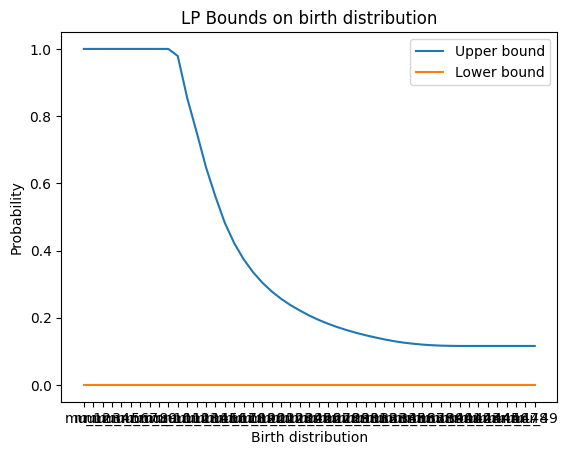

In [26]:
# select gene from observed counts
sample_obs = data_OB.iloc[1483]
# run process
solution_B = bound_sample_B(sample_obs, plot_sample=True, print_bounds=True, print_status=True, plot_solution=True)

### Compare to solution directly using upscaled counts

Bootstrap: 0.25520825386047363
Bounds: 0.0


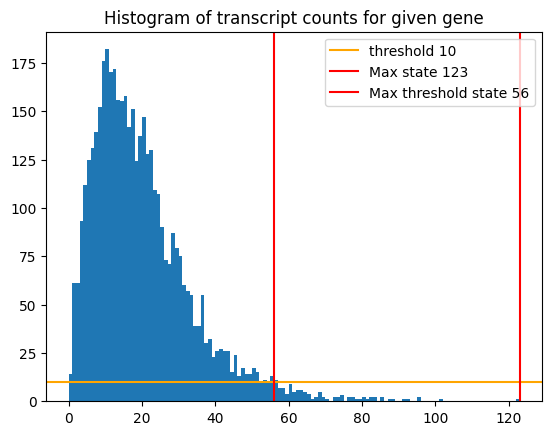

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 15.615056037902832
N = 56 feasible:
reduction to feasible: 0.0


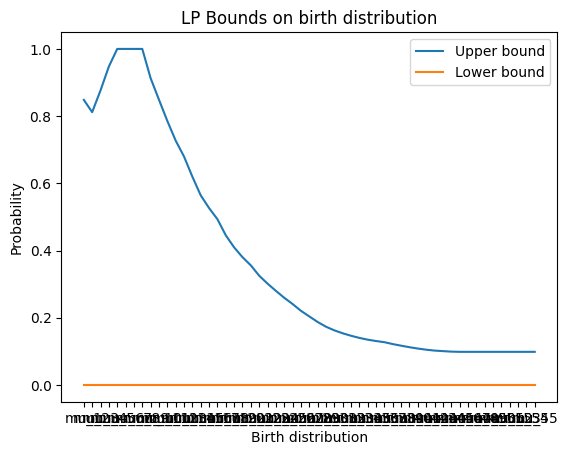

In [28]:
# select same gene from upscaled counts
sample_ps = data_PS.iloc[1483]
# solve using standard LP method
solution_ps = bound_sample_refined_optim(sample_ps, threshold=10)

See that the solution produced using B upscaling of observed counts is similar to the solution produced using BayNorm upscaled counts (posterior samples), suggesting that the methods are consistent with each other.

# Simulating Downsampled Data

So far we have worked with real cell-sequencing data where the collection method suffers from low capture efficiency, and have used upscaling methods such as BayNorm and the B method to estimate and make inference about the true counts. However, working with real data is difficult as the 'true' (upscaled) count data is not availble, nor are the 'true' parameters and so we cannot test the validity of solutions.

We return to using simulated data, where the ground truth is known:
- set reaction rate parameters
- use gillespie to simulate 'true' count stationary samples
- set capture efficiency
- use binomial to 'downsample' to 'observed' count stationary samples

We can then perform analysis using the 'observed' data, comparing the results to those produced using the 'true' data, and the true parameter values.

In [22]:
def sample_path_bursty(initial_state, params, tmax, plot=False):
    """
    Simulate a sample path of bursty gene expression

    Inputs:
    initial state: positive integer initial value of path
    params: [k0, k1, b] positive values of reaction rates and geometric dist parameter
    tmax: length of sample path
    plot: whether to plot the sample path

    Outputs:
    path: list of visited states
    jump_times: list of state transition times
    """

    # initialise time and state (also store jump times)
    t = 0
    path = [initial_state]
    jump_times = [0]
    k0, k1, b = params[0], params[1], params[2]

    # simulate until stopping time
    while t < tmax:
        # simulate holding time of current state (x)
        x = path[-1]

        # define rates
        # degradation: q(x,x-1) = k1x
        q_deg = k1 * x
        # -q(x,x): holding rate = sum q(x,y) over y
        q_hold = k1 * x + k0
        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold

        # simulate degradation or burst
        jump = np.random.choice([0,1],p=[q_deg / q_hold, 1 - q_deg / q_hold])
        # degradation
        if jump == 0:
            path.append(x - 1)
        # bursting
        else:
            # simulate m = geom(b)
            m = np.random.geometric(b)
            path.append(x + m)

    if plot:
        # plot path against jump times
        plt.step(jump_times, path, where='post')
        plt.xlabel("Time")
        plt.ylabel("Number of molecules")
        plt.show()

    return path

In [23]:
def sample_path_approximate(x0, params, n, tmax, ts, plot=False):
    """
    Simulate a single sample path of birth death reaction
    Sample values at intervals ts after a burn-in time of tmax to give n values

    x0 = initial state
    params = [k0, k1, b]
    n = total number of samples
    tmax = burn-in simulation time
    ts = time between successive samples

    return states visited and jump times
    """

    # parameters
    k0 = params[0]
    k1 = params[1]
    b = params[2]

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate for: burn-in time + (n-1) times between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x = path[-1]

        # rates
        q_deg = k1 * x
        q_hold = k1 * x + k0

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        # degradation
        if u < q_deg / q_hold:
            path.append(x - 1)
        # bursting
        else:
            # simulate m = geom(b)
            m = np.random.geometric(b)
            path.append(x + m)

    # create step function of sample path from jump times and jump values
    path_function = scipy.interpolate.interp1d(jump_times, path, kind='previous')
    
    # take values at sampling times as samples
    sample_times = [tmax + i * ts for i in range(n)]
    samples = path_function(sample_times)
    samples = np.array([int(x) for x in samples])

    # plot sample path with burn-in and sampled values
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, path_function(x), label="Sample path")
        plt.axvline(tmax, label="Burn-in time: t_max", color="orange")
        plt.scatter(sample_times, path_function(sample_times), color="red", label="Samples")
        plt.legend()
        plt.show()

    return samples

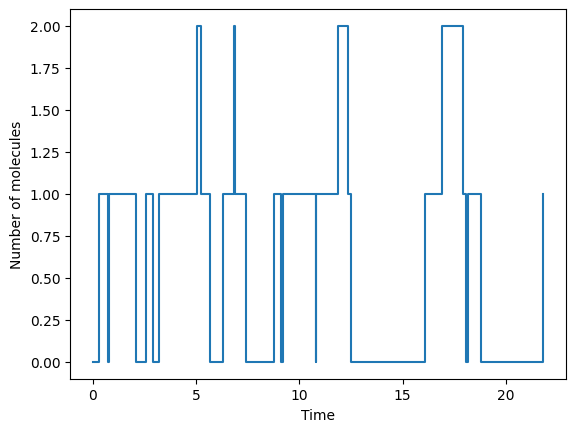

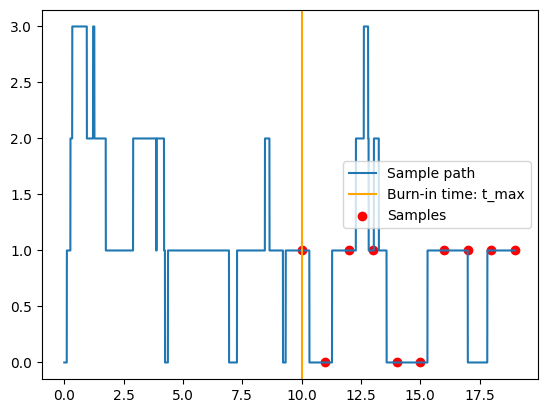

In [24]:
params = [1, 1, 1]
path_1 = sample_path_bursty(0, params, 20, plot=True)
path_2 = sample_path_approximate(0, params, 10, 10, 1, plot=True)

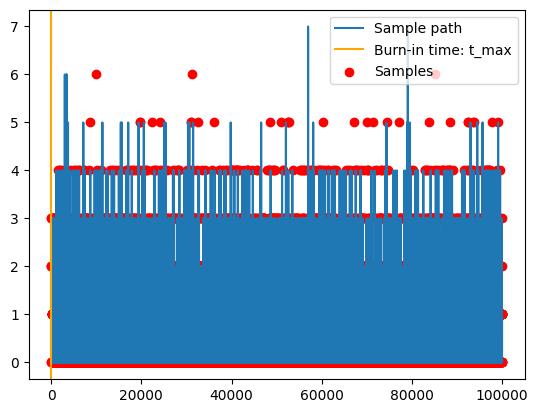

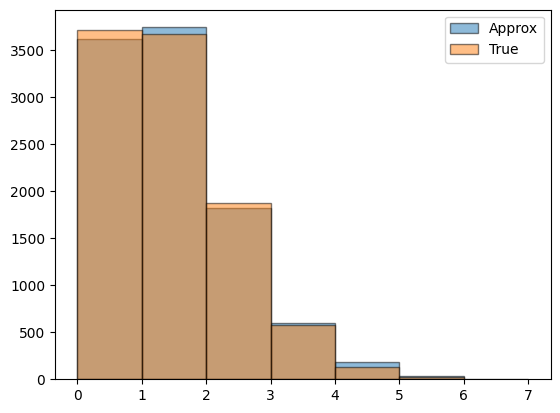

In [44]:
# sample of size 1000 from approx method
samples_approx = sample_path_approximate(0, params, 10000, 10, 10, plot=True)
# true stationary dist is poisson(k1 / k2) for b = 1 (i.e. BD case)
samples_true = np.random.poisson(params[0]/ params[1], size=10000)
plt.hist(samples_approx, bins=np.max(samples_approx), alpha=0.5, ec="black", label="Approx")
plt.hist(samples_true, bins=np.max(samples_true), alpha=0.5, ec="black", label="True")
plt.legend()
plt.show()

So 'approximate' sampling is consistent with true stationary dist and so can be used to speed up

In [41]:
def simulated_samples(params, n, beta, tmax, ts, plot_path=False, plot_true=False, plot_downsampled=False):
    '''
    Simulate 'true' and 'downsampled' samples of size n from the burst reaction.

    Input:
    params: [k0, k1, b] reaction parameters
    beta: capture efficicency for downsampling
    tmax: burn in time for sample paths
    ts: time between samples
    plot_path: plot sample path
    plot_true: histogram of true sample
    plot_downsampled: histogram of downsampled sample

    Output:
    sample_true: true sample of size n
    sample_downsampled: downsampled sample of size n
    '''
    # simulate 'true' sample of size n
    sample_true = sample_path_approximate(0, params, n, tmax, ts, plot=plot_path)

    # for each count, draw from Binomial(count, beta)
    sample_downsampled = np.random.binomial(sample_true, beta)

    # plot histograms
    if plot_true:
        plt.hist(sample_true, bins=np.max(sample_true))
        plt.title("Histogram of samples from true stationary distribution")
        plt.xlabel("True counts")
        plt.show()
    if plot_downsampled:
        plt.hist(sample_downsampled, bins=np.max(sample_downsampled))
        plt.title("Histogram of samples from downsampled stationary distribution")
        plt.xlabel(f"Observed counts, beta = {beta}")
        plt.show()

    return {'sample_true': sample_true, 'sample_downsampled': sample_downsampled}

### Test

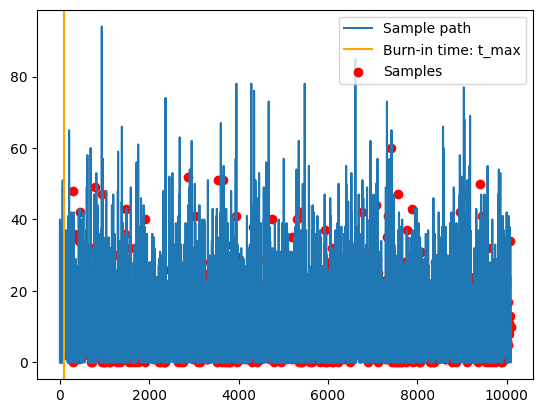

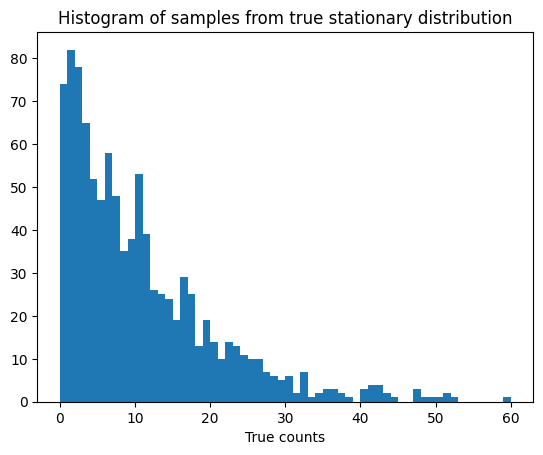

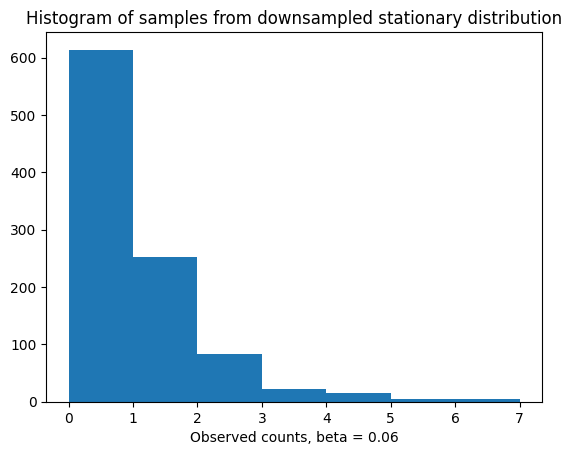

In [42]:
s = simulated_samples(params=[1, 1, 0.1], n=1000, beta=0.06, tmax=100, ts=10, plot_path=True, plot_true=True, plot_downsampled=True)

# Test and Compare B method

## Modify functions to allow manual selection

Modify sample path / simulation to accept arbitrary discrete distributions

Modify optimized bootstrap to accept non-series inputs

Modify B matrix computation to accept float / list values of beta

Modify the LP B solver to take manuallly specified beta value(s)

Modify the B method to allow manual $x_{max}$ and $x_{max_0}$ selection, and remove threshold/skip options used for data work.

In [62]:
def sample_path(x0, params, n, tmax, ts, plot=False):
    """
    Simulate a single sample path of birth death reaction
    Sample values at intervals ts after a burn-in time of tmax to give n values

    x0 = initial state
    params = dictionary of k0, k1, geometric parameter b or discrete distribution
    n = total number of samples
    tmax = burn-in simulation time
    ts = time between successive samples

    return states visited and jump times
    """

    # reaction parameters
    k0 = params["k0"]
    k1 = params["k1"]
    try:
        # geometric bursts
        b = params["b"]
        geom = True
    except KeyError:
        # discrete distribution of bursts
        pi = params["pi"]
        geom = False

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate for: burn-in time + (n-1) times between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x = path[-1]

        # rates
        q_deg = k1 * x
        q_hold = k1 * x + k0

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        # degradation
        if u < q_deg / q_hold:
            path.append(x - 1)
        # bursting
        else:
            # sample m from geom(b) OR pi distribution
            if geom:
                m = np.random.geometric(b)
            else:
                # pi[i] = P(state i + 1)
                m = np.random.choice(range(1, len(pi) + 1), p=pi)
            path.append(x + m)

    # create step function of sample path from jump times and jump values
    path_function = scipy.interpolate.interp1d(jump_times, path, kind='previous')
    
    # take values at sampling times as samples
    sample_times = [tmax + i * ts for i in range(n)]
    samples = path_function(sample_times)
    samples = np.array([int(x) for x in samples])

    # plot sample path with burn-in and sampled values
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, path_function(x), label="Sample path")
        plt.axvline(tmax, label="Burn-in time: t_max", color="orange")
        plt.scatter(sample_times, path_function(sample_times), color="red", label="Samples")
        plt.legend()
        plt.show()

    return samples

In [64]:
def simulated_samples(params, n, beta, tmax, ts, plot_path=False, plot_true=False, plot_downsampled=False):
    '''
    Simulate 'true' and 'downsampled' samples of size n from the burst reaction.

    Input:
    params = dictionary of k0, k1, geometric parameter b or discrete distribution
    beta: capture efficicency for downsampling
    tmax: burn in time for sample paths
    ts: time between samples
    plot_path: plot sample path
    plot_true: histogram of true sample
    plot_downsampled: histogram of downsampled sample

    Output:
    sample_true: true sample of size n
    sample_downsampled: downsampled sample of size n
    '''
    # simulate 'true' sample of size n
    sample_true = sample_path(0, params, n, tmax, ts, plot=plot_path)

    # for each count, draw from Binomial(count, beta)
    sample_downsampled = np.random.binomial(sample_true, beta)

    # plot histograms
    if plot_true:
        plt.hist(sample_true, bins=np.max(sample_true))
        plt.title("Histogram of samples from true stationary distribution")
        plt.xlabel("True counts")
        plt.show()
    if plot_downsampled:
        plt.hist(sample_downsampled, bins=np.max(sample_downsampled))
        plt.title("Histogram of samples from downsampled stationary distribution")
        plt.xlabel(f"Observed counts, beta = {beta}")
        plt.show()

    return {'sample_true': sample_true, 'sample_downsampled': sample_downsampled}

In [45]:
def bootstrap_data_optim(samples, N, plot=False, printing=False, drop_missing=False):
    """
    Bootstrap sample data to find confidence intervals of
    stationary distribution values.

    Inputs:
    samples: sample from stationary distribution (counts of transcripts)
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's
    drop_missing: whether to drop missing values from the sample,
        or replace them with 0 (as used when preparing BayNorm data)

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of all states up to largest observed
    """
    # change to series
    samples = pd.Series(samples)

    # drop missing values
    if drop_missing:
        samples = samples.dropna()
    # replace with 0
    else:
        samples = samples.fillna(value=0.0)

    # change to int
    samples = samples.astype('int64')
    # maximum state observed
    x_max = int(np.nanmax(samples))
    # size of sample
    n = len(samples)

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(samples, size=(N, n))
    # produce N x (x_max + 1) array of counts of states:
    # offset each row by multiple of x_max + 1 for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(x_max + 1)]

    # plot histograms and CI
    for x in range(x_max + 1):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
        if plot:
            plt.hist(counts[:, x] / n)
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[x][0], color="red")
            plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

In [46]:
def B_matrix(beta, x_max, x_max_0):
    """
    Construct the binomial upscaling matrix B

    Arguments:
    beta: capture efficiencies for each cell
    x_max: observed truncation T = {0, ... , x_max}
    x_max_0: 'true' truncation T_0 = {0, ..., x_max_0}

    Returns:
    B: |T| x |T_0| upscaling matrix (x_max + 1, x_max_0 + 1)
    """
    if type(beta) == pd.core.frame.DataFrame:
        beta_list = list(beta['x'])
    elif type(beta) == float or type(beta) == int:
        beta_list = [beta]
    else:
        beta_list = beta

    # initialise B
    B = np.zeros((x_max + 1, x_max_0 + 1))
    # loop over beta_j values
    for beta_j in beta_list:
        # create B_j matrix
        f = lambda x, x0: scipy.special.comb(x0, x) * beta_j**x * (1 - beta_j)**(x0 - x)
        B_j = np.fromfunction(f, (x_max + 1, x_max_0 + 1))
        # add to B
        B += B_j
    # scale B
    B = B / len(beta_list)
    return B

In [47]:
def bursty_LP_B(intervals, beta, x_max, x_max_0, mean_true_ub, k0=None, k1=None, M=None):
    """
    Solve the butsty LP system for interval bounds on parameters,
    upscaling observed data into true count data using B matrix

    Inputs:
    intervals: confidence intervals on observed count stationary distribution
    beta: capture efficiency/ies {allows single value or multiple as list/etc}
    x_max: use observed bounds p(0), ..., p(x_max)
    x_max_0: use upscaled bounds p(0), ..., p(x_max_0)
    mean_true_ub: upper bound on expected value of upscaled counts E[X^0]
    k0, k1: fixed values of parameters

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # observed bounds from CI
    pl_obs = [intr[0] for intr in intervals]
    pu_obs = [intr[1] for intr in intervals]

    # select observed bounds on p(0), ..., p(x_max)
    pl_obs = np.array(pl_obs)[:x_max + 1]
    pu_obs = np.array(pu_obs)[:x_max + 1]

    # compute upscaling B matrix
    B = B_matrix(beta, x_max, x_max_0)

    # number of equations N = x_max_0
    N = x_max_0

    # compute uppper bound on truncation error
    t_bound = mean_true_ub / (x_max_0 + 1)

    # estikmate up to largest burst size (unless otherwise specified)
    if not M:
        M = N - 1
    
    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # Construct the problem

    # Variables: unless k0 or k1 are fixed
    if not k0:
        k0 = cv.Variable()
    if not k1:
        k1 = cv.Variable()
    mu = cv.Variable(M)
    z0 = cv.Variable(N + 1)
    z1 = cv.Variable(N + 1)
    y = cv.Variable((N + 1, M))

    # constraints
    constraints = [
        # Qp = 0
        Q1 @ z1 + Q00 @ z0 + sum([Q0(m + 1) @ y[:, m] for m in range(0, M)]) == 0,
        # non-neg
        k0 >= 0, k1 >= 0, mu >= 0, z0 >= 0, z1 >= 0, y >= 0,
        # upscaled observed bounds
        k0 * pl_obs - k0 * t_bound <= B @ z0, B @ z0 <= k0 * pu_obs,
        k1 * pl_obs - k1 * t_bound <= B @ z1, B @ z1 <= k1 * pu_obs,
        # burst distribution constraints
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([mu[m] for m in range(0, M)]) <= k0,
        # dist. const.
        sum([z0[x] for x in range(N + 1)]) <= k0,
        sum([z1[x] for x in range(N + 1)]) <= k1
    ]
    for m in range(0, M):
        constraints +=  [
            # upscaled observed counts
            mu[m] * pl_obs - mu[m] * t_bound <= B @ y[:, m], B @ y[:, m] <= mu[m] * pu_obs,
            # dist. const.
            sum([y[x, m] for x in range(N + 1)]) <= mu[m]
        ]

    # Objective
    c = cv.Parameter(M)
    objective = c @ mu
    objective_min = cv.Minimize(objective)
    objective_max = cv.Maximize(objective)

    # solution interval dict
    solutions = {}

    # values of c parameter: e_1, ..., e_M+2
    c_values = [[1 if i == j else 0 for j in range(M)] for i in range(M)]

    # create problem
    prob_min = cv.Problem(objective_min, constraints)
    prob_max = cv.Problem(objective_max, constraints)

    # variable names
    var_names = [f"mu_{m + 1}" for m in range(M)]

    # repeatedly solve
    for i, c_val in enumerate(c_values):
        # variable
        var_name = var_names[i]
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = c_val
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    
    return solutions

In [48]:
def mean_CI(sample):
    '''Compute 95% confidence interval for the mean of the sample.'''
    # sample mean
    mean = np.mean(sample)
    # sample standard deviation
    std = np.std(sample)
    # size of the sample
    n = len(sample)
    # compute CI
    return (mean - 1.96 * (std / np.sqrt(n)), mean + 1.96 * (std / np.sqrt(n)))

In [49]:
def bound_sample_B_test(sample, beta, n=1000, x_max=None, x_max_0=None, 
                         print_bounds=False, plot_solution=True):
    """
    Given transcript counts observed from genes,
    bootstrap and solve LP by upscaling into true counts,
    produce bounds on parameters

    Arguments:
    sample: list of observed transcript counts
    beta: capture efficiency/ies {allows single value or multiple as list/etc}
    n: number of bootstrap samples
    x_max: use bounds on p(0), ... , p(x_max) from sample
    x_max_0: upscale to p(0), ... ,p(x_max_0)

    Settings:
    plot_sample: toggle histogram of sample
    print_bounds: toggle printing CI bounds
    print_status: toggle printing feasible/infeasible reports
    plot_solution: toggle plotting solution bounds on distribution

    Returns:
    dictionary of solution intervals for parameters
    """
    # select x_max: largest observed count to be used
    if x_max is None:
        # largest observed count
        x_max = int(np.nanmax(sample))
        print(f"x_max = {x_max}")

    # compute all possible observed bounds: p(0), ..., p(x_max)
    intervals = bootstrap_data_optim(sample, n, printing=print_bounds)

    # compute upper bound on mean of observed sample E[X]
    mean_ob_ub = mean_CI(sample)[1]

    # calculate upper bound on mean of true sample E[X^0]
    mean_beta = np.mean(beta)
    mean_true_ub = mean_ob_ub / mean_beta

    # select x_max_0: largest upscaled count to be computed
    if x_max_0 is None:
        x_max_0 = int(x_max / mean_beta)
        print(f"x_max_0 = x_max / <beta> = {x_max / mean_beta}")

    # solve LP using inputs x_max, x_max_0
    solutions_dist = bursty_LP_B(intervals, beta, x_max, x_max_0, mean_true_ub, k0=1)

    # estimating pi_1, ..., pi_M
    M = x_max_0 - 1

    # plot
    if plot_solution:
        # extract distribution bounds
        labels = [f'mu_{m}' for m in range(1, M + 1)]
        lower = [solutions_dist[var][0] for var in labels]
        upper = [solutions_dist[var][1] for var in labels]
        plt.plot(labels, upper, label = "Upper bound")
        plt.plot(labels, lower, label = "Lower bound")
        plt.title("LP Bounds on birth distribution")
        plt.ylabel("Probability")
        plt.xlabel("Birth distribution")
        plt.legend()
        plt.show()

    # return bounds
    return solutions_dist

## Compare

- set reaction parameters, capture efficiency
- simulate true $\{x_0\}$ and observed (downsampled) $\{x\}$ samples
- B method: set $x_{max}$ and $x_{max_0}$, use $\{x\}$ to estimate $\pi_B$
- standard method: set $x_{max_0}$, use $\{x_0\}$ to estimate $\pi_{standard}$
- compare: plot $\pi_B$, $\pi_{standard}$ and the true burst distribution $\pi$

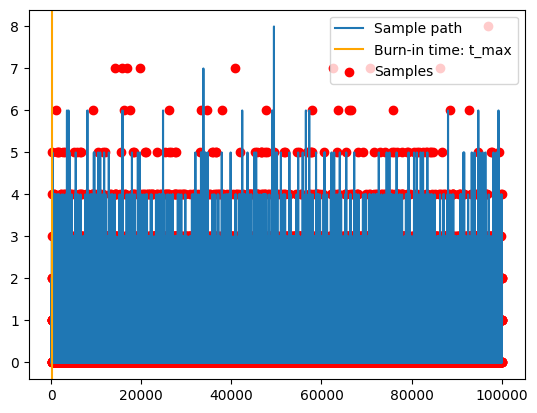

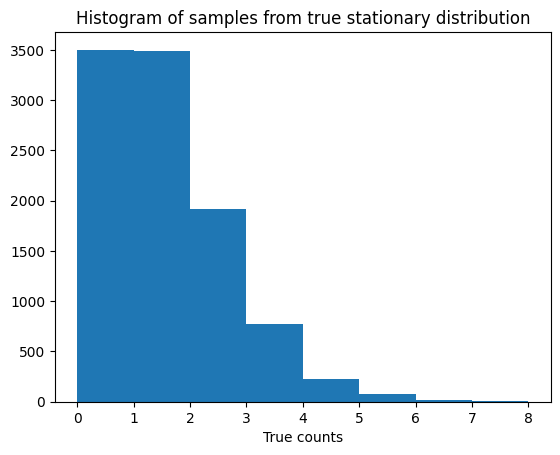

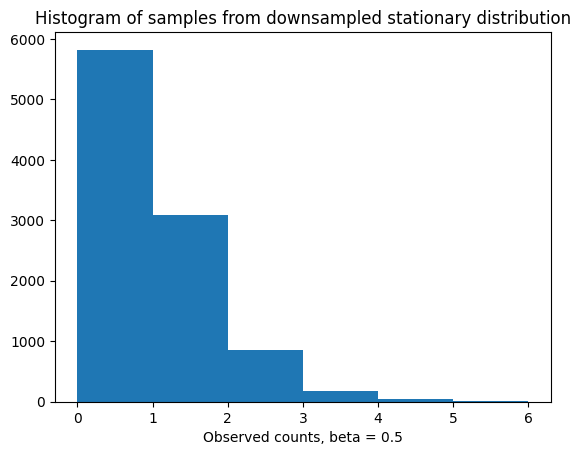

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


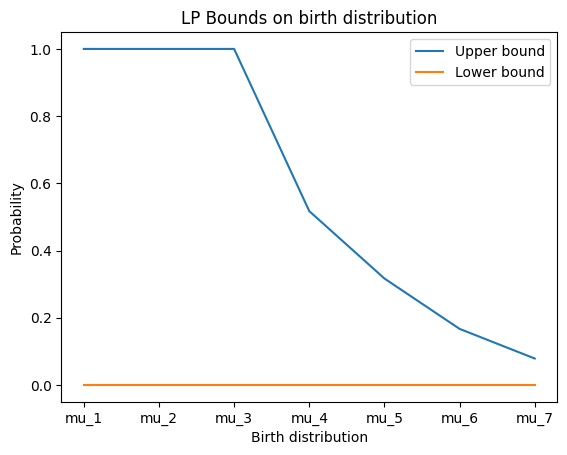

Bootstrap: 0.3169078826904297
Bounds: 0.01683497428894043


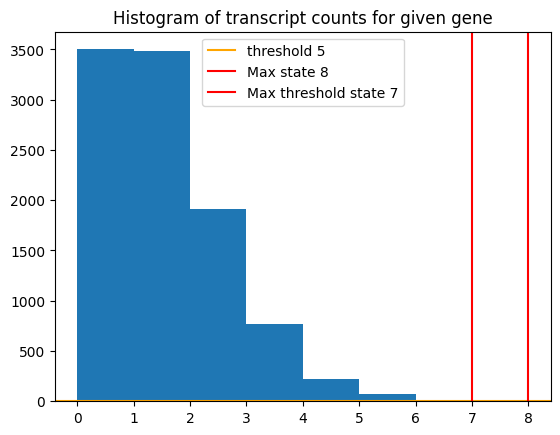

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.133467435836792
N = 7 feasible:
reduction to feasible: 0.0


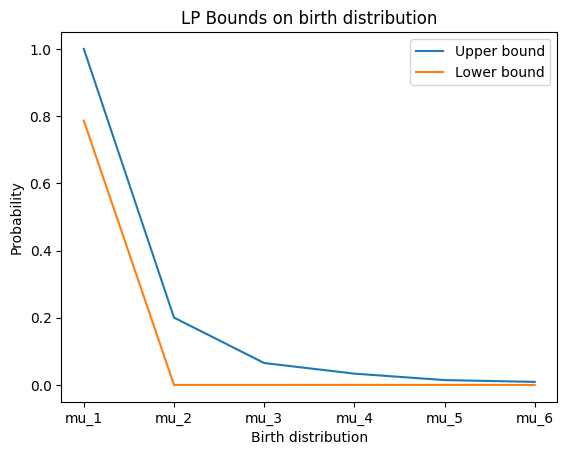

In [65]:
# set parameters
params = {"k0": 1, "k1": 1, "b": 0.9}
beta = 0.5

# simulate samples
samples = simulated_samples(params=params, n=10000, beta=beta, tmax=100, ts=10, plot_path=True, plot_true=True, plot_downsampled=True)

# B method
# select x_max, x_max_0: use information from true sample (do not have in practice)
x_max = np.nanmax(samples['sample_downsampled'])
x_max_0 = np.nanmax(samples['sample_true'])
# solve for pi_B
solution_B = bound_sample_B_test(samples['sample_downsampled'], beta=beta, n=1000, x_max=x_max, x_max_0=x_max_0, plot_sample=True, print_bounds=False, print_status=True, plot_solution=True)

# standard method
# select x_max_0
x_max_0 = np.nanmax(samples['sample_true'])
# solve for pi_standard
solution_standard = bound_sample_refined_optim(pd.Series(samples['sample_true']), threshold=5, skip=1, n=1000, N=None, plot_sample=True, print_bounds=False, print_status=True, plot_solution=True)

Plot against true burst distribution:

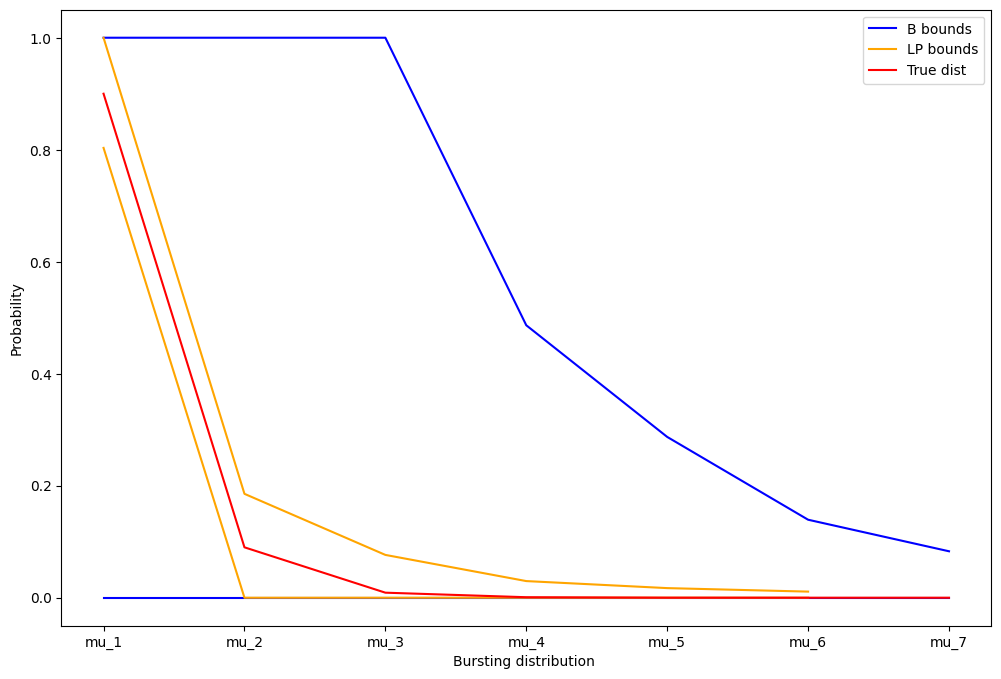

In [56]:
# true burst distirubion: geometric(b)
M = max(len(solution_B), len(solution_standard))
dist_true = [b * (1 - b)**m for m in range(0, M)]
labels_true = [f'mu_{m}' for m in range(1, M + 1)]

# B bounds
lower_B = [val[0] for val in solution_B.values()]
upper_B = [val[1] for val in solution_B.values()]
labels_B = [key for key in solution_B.keys()]

# standard bounds
lower_std = [val[0] for val in solution_standard.values()]
upper_std = [val[1] for val in solution_standard.values()]
labels_std = [key for key in solution_standard.keys()]

# plot
plt.figure(figsize=(12,8))
plt.plot(labels_B, upper_B, label = "B bounds", color="blue")
plt.plot(labels_B, lower_B, color="blue")
plt.plot(labels_std, upper_std, label = "LP bounds", color="orange")
plt.plot(labels_std, lower_std, color="orange")
plt.plot(labels_true, dist_true, label = "True dist", color="red")
plt.ylabel("Probability")
plt.xlabel("Bursting distribution ")
plt.legend()
plt.show()

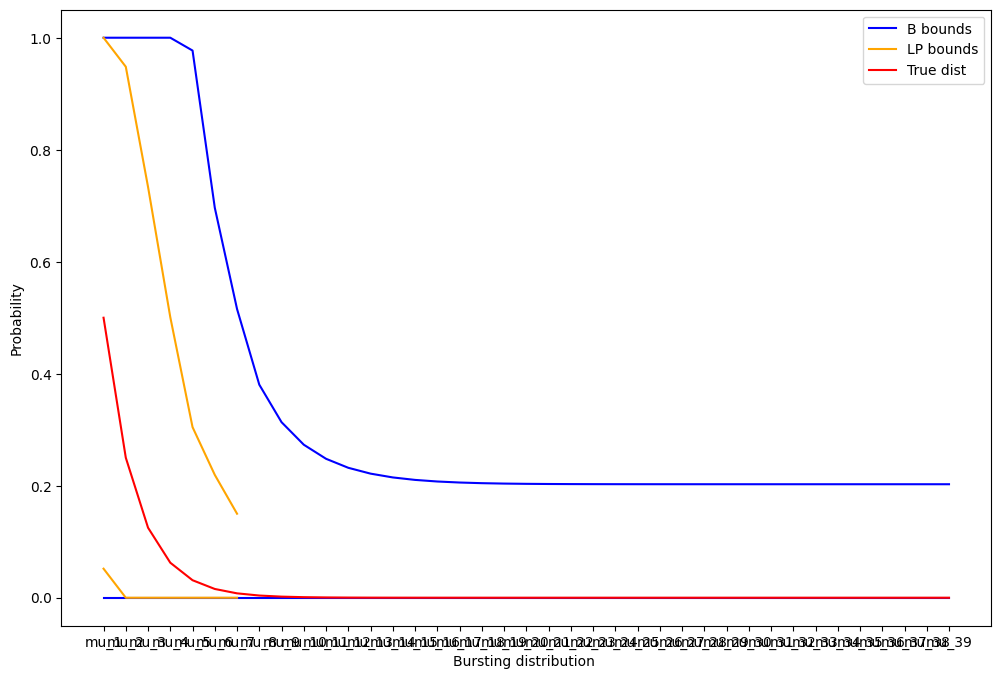

In [78]:
# true burst distirubion: geometric(b)
M = max(len(solution_B), len(solution_standard))
dist_true = [b * (1 - b)**m for m in range(0, M)]
labels_true = [f'mu_{m}' for m in range(1, M + 1)]

# B bounds
lower_B = [val[0] for val in solution_B.values()]
upper_B = [val[1] for val in solution_B.values()]
labels_B = [key for key in solution_B.keys()]

# standard bounds
lower_std = [val[0] for val in solution_standard.values()]
upper_std = [val[1] for val in solution_standard.values()]
labels_std = [key for key in solution_standard.keys()]

# plot
plt.figure(figsize=(12,8))
plt.plot(labels_B, upper_B, label = "B bounds", color="blue")
plt.plot(labels_B, lower_B, color="blue")
plt.plot(labels_std, upper_std, label = "LP bounds", color="orange")
plt.plot(labels_std, lower_std, color="orange")
plt.plot(labels_true, dist_true, label = "True dist", color="red")
plt.ylabel("Probability")
plt.xlabel("Bursting distribution ")
plt.legend()
plt.show()

# Parameter and Hyperparameter influence

We want to test how the B-method behaves for different reaction rate parmeters of the simulated data: short / long geometric distributions, fast / slow reaction rates, even different distributions of bursts. Initial test on real data showed that it can produce comparable results to baynorm, but in this simulated setting we are able to compare results to the truth to get a measure of performance.

However, we also need to test the best 'hyperparameters' to use: the truncation sizes $x_{max}$ and $x_{max_0}$:
- $x_{max}$ plays much the same role as before, the largest bootstrapped CI from the observed data that can be trusted to be accurate, usually based off a truncation argument.
- $x_{max_0}$ is independent of $x_{max}$ and controlls the size of the upscaled distribution, and so the number of $\pi$'s estimated. 

The independence of the 2 parameters is an advantage over baynorm, where the truncation of the computed CI's directly controls the number of $\pi$'s estimated (could in practice add [0,1] bounds to estimate more values, but somehow less useful)

### Hyperparameters

Given a 'short' distribution, such as Geom(0.9) seen above